# Final Project
### Name: Shrinidhi Rajesh
### ID: 2132508
### Class: CSC 583 - Natural Language Processing

In [24]:
# List of required Python libraries and their versions for building, analyzing, and evaluating the Retrieval-Augmented Generation (RAG) system.
%%writefile requirements.txt

chromadb==0.5.0
datasets==2.19.1
gdown==5.2.0
langchain==0.2.0
langchain-community==0.2.0
langchain-experimental==0.0.59
langchain-openai==0.1.7
langdetect==1.0.9
lorem-text==2.1
nbformat>=4.2.0
plotly==5.22.0
pretty-jupyter==1.0
ragas==0.1.8
seaborn==0.13.2
sentence-transformers==3.0.0
spacy>=3.7
textstat==0.7.3
umap-learn==0.5.5

Overwriting requirements.txt


In [25]:
# Installing PyTorch library
%pip install torch==2.5.0

In [26]:
# Installing the Requirements
%pip install -r ./requirements.txt --quiet

In [3]:
# Importing the necessary libraries
import json
import os
import warnings
import zipfile
from collections import Counter
from pathlib import Path
from typing import Dict, List
import chromadb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import torch
from chromadb import Collection, Documents, EmbeddingFunction, Embeddings
from datasets import Dataset
from dotenv import load_dotenv
from langdetect import detect
from lorem_text import lorem
from ragas import RunConfig, evaluate
from ragas.metrics import (faithfulness, answer_relevancy, context_relevancy, answer_correctness)
from spacy.lang.en import English
from textstat import flesch_reading_ease
from tqdm import tqdm
import umap
from langchain.chains.base import Chain
from langchain.text_splitter import RecursiveCharacterTextSplitter, TextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, VectorStore
from langchain_core.callbacks import CallbackManagerForRetrieverRun
from langchain_core.documents import Document
from langchain_core.embeddings import Embeddings
from langchain_core.language_models import LLM
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.retrievers import BaseRetriever
from langchain_core.runnables import RunnableParallel, RunnablePassthrough
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
import torch
# !pip install python-dotenv
from dotenv import load_dotenv
from google.colab import drive
import os
from pathlib import Path
import nltk
nltk.download('punkt_tab')
from typing import Dict
from evaluate import load

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
%%writefile .env

OPENAI_API_KEY= sk-XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX # Hiding it for security reasons


Writing .env


In [ ]:
# Loading environment variables from .env file
load_dotenv()

# Accessing the API key
api_key = os.getenv("OPENAI_API_KEY")

In [30]:
# Initializing the language model
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

# Defining a question prompt template
question_prompt = ChatPromptTemplate.from_template(
    "Answer the following question: {question}")
question_chain = question_prompt | llm | StrOutputParser()
question_chain.invoke({"question": "What is the meaning of life?"})

'The meaning of life is a deeply philosophical question that has been debated by scholars, theologians, and individuals for centuries. Some believe that the meaning of life is to seek happiness and fulfillment, while others believe it is to fulfill a higher purpose or destiny. Ultimately, the meaning of life is a subjective concept that may vary from person to person based on their beliefs, values, and experiences.'

In [5]:
## Code piece to mount my Google Drive
drive.mount("/content/drive") # my Google Drive root directory will be mapped here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Changing the working directory to my work directory (where the code file is).
thisdir = '/content/drive/My Drive/Colab Notebooks/Final Project Updated'
os.chdir(thisdir)

# Ensuring if the files are there (in the folder)
!pwd

/content/drive/My Drive/Colab Notebooks/Final Project Updated


In [33]:
# Checking the current working directory
os.chdir(thisdir)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/drive/My Drive/Colab Notebooks/Final Project Updated


In [15]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print ('There are %d GPU(s) available.' % torch.cuda.device_count())
    print ('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print ('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [16]:
# Reading the dataset into a DataFrame
articles_df = pd.read_csv("cleantech_media_dataset_v3_2024-10-28.csv", encoding='utf-8', index_col=0)
# Displaying the first few rows of the dataset
articles_df.head()

,title,date,author,content,domain,url
93320,"XPeng Delivered ~100,000 Vehicles In 2021",2022-01-02,NaN,['Chinese automotive startup XPeng has shown o...,cleantechnica,https://cleantechnica.com/2022/01/02/xpeng-del...
93321,Green Hydrogen: Drop In Bucket Or Big Splash?,2022-01-02,NaN,['Sinopec has laid plans to build the largest ...,cleantechnica,https://cleantechnica.com/2022/01/02/its-a-gre...
98159,World’ s largest floating PV plant goes online...,2022-01-03,NaN,['Huaneng Power International has switched on ...,pv-magazine,https://www.pv-magazine.com/2022/01/03/worlds-...
98158,Iran wants to deploy 10 GW of renewables over ...,2022-01-03,NaN,"['According to the Iranian authorities, there ...",pv-magazine,https://www.pv-magazine.com/2022/01/03/iran-wa...
31128,Eastern Interconnection Power Grid Said ‘ Bein...,2022-01-03,NaN,['Sign in to get the best natural gas news and...,naturalgasintel,https://www.naturalgasintel.com/eastern-interc...


In [19]:
human_eval_df = pd.read_csv("cleantech_rag_evaluation_data_2024-09-20.csv", delimiter=';', encoding='utf-8', index_col=0)
human_eval_df.head()

,question_id,question,relevant_text,answer,article_url
example_id,,,,,
1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,https://www.sgvoice.net/strategy/technology/23...
2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,https://www.sgvoice.net/policy/25396/eu-seeks-...
3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,https://www.pv-magazine.com/2023/02/02/europea...
4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,https://www.sgvoice.net/policy/25396/eu-seeks-...
5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,https://cleantechnica.com/2023/05/08/general-m...


In [47]:
# Extracting relevant columns for understanding
questions = human_eval_df['question']
relevant_texts = human_eval_df['relevant_text']
answers = human_eval_df['answer']

# Displaying the extracted data
print("Questions:")
print(questions)
print("\nRelevant Texts:")
print(relevant_texts)
print("\nAnswers:")
print(answers)

Questions:
example_id
1     What is the innovation behind Leclanché's new ...
2          What is the EU’s Green Deal Industrial Plan?
3          What is the EU’s Green Deal Industrial Plan?
4     What are the four focus areas of the EU's Gree...
5     When did the cooperation between GM and Honda ...
6     Did Colgate-Palmolive enter into PPA agreement...
7     What is the status of ZeroAvia's hydrogen fuel...
8                          What is the "Danger Season"?
9                      Is Mississipi an anti-ESG state?
10          Can you hang solar panels on garden fences?
11    Who develops quality control systems for ocean...
12    Why are milder winters detrimental for grapes ...
13    What are the basic recycling steps for solar p...
14    Why does melting ice contribute to global warm...
15    Does the Swedish government plan bans on new p...
16    Where do the turbines used in Icelandic geothe...
17          Who is the target user for Leapfrog Energy?
18                        

### Training Data Set


In [48]:
# Explorative Data Analysis & Preprocessing
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20111 entries, 93320 to 101431
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    20111 non-null  object 
 1   date     20111 non-null  object 
 2   author   0 non-null      float64
 3   content  20111 non-null  object 
 4   domain   20111 non-null  object 
 5   url      20111 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.6+ MB


In [49]:
# Dropping the author column since it contains 0 non null values
articles_df = articles_df.drop(columns=["author"])

In [50]:
# plot the amount of articles over time
articles_df["date"] = pd.to_datetime(articles_df["date"])
time_df = articles_df.groupby("date").size().reset_index()
time_df.columns = ["date","count"]

# Sorting by 'count' in descending order and get top 5
time_df_sorted = time_df.sort_values(by="count", ascending=False).head(10)

# Printing the results
print(time_df_sorted)

          date  count
507 2023-06-13   1812
508 2023-06-14   1493
468 2023-05-04    430
509 2023-06-15    340
464 2023-04-30    111
715 2024-01-11     53
622 2023-10-07     53
653 2023-11-08     49
618 2023-10-03     49
579 2023-08-25     46


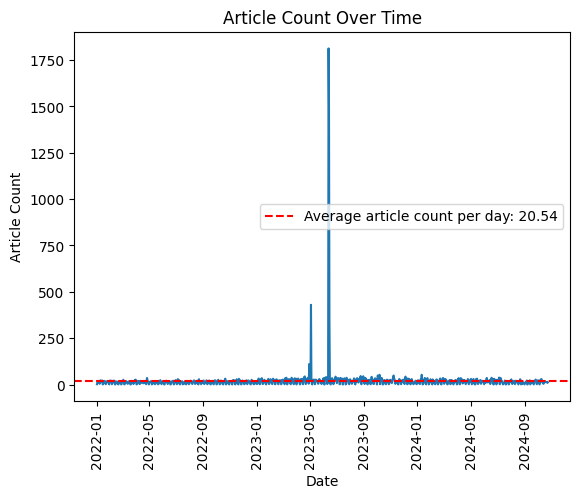

In [51]:
sns.lineplot(data=time_df, x="date", y="count")
plt.title("Article Count Over Time")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.ylabel("Article Count")
# add a line for the average
avg_count = time_df["count"].mean()
plt.axhline(avg_count, color='r', linestyle='--', label=f"Average article count per day: {avg_count:.2f}")
plt.legend()
plt.show()

In [52]:
# Dropping the date column
articles_df = articles_df.drop(columns=["date"])

In [53]:
# Analyzing domain counts
domain_counts = articles_df["domain"].value_counts()
domain_counts

,count
domain,
energy-xprt,4181
pv-magazine,3093
azocleantech,2488
cleantechnica,2089
pv-tech,1969
thinkgeoenergy,1052
solarpowerportal.co,850
energyvoice,828
solarpowerworldonline,785


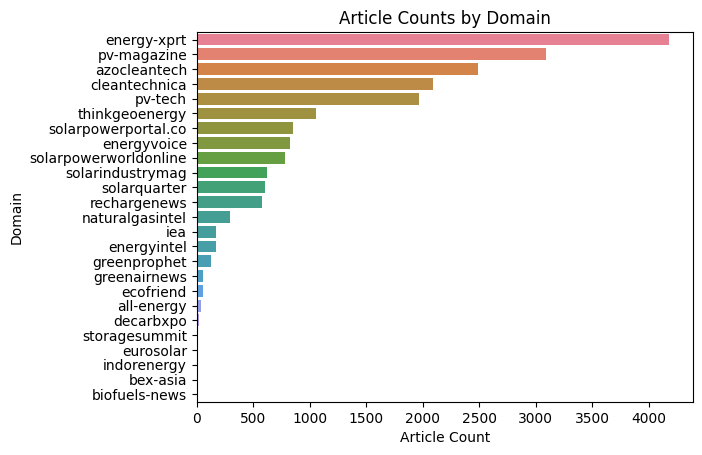

In [44]:
barplot = sns.barplot(
    x=domain_counts.values,
    y=domain_counts.index,
    hue=domain_counts.index
)

barplot.set_title('Article Counts by Domain')
barplot.set_xlabel('Article Count')
barplot.set_ylabel('Domain')

plt.show()

In [54]:
# Article Titles
# Counting duplicated titles
print(articles_df["title"].duplicated().sum())

95


In [55]:
# Extracting and sorting duplicated titles
duplicate_titles = articles_df[articles_df["title"].duplicated(keep=False)].sort_values("title")

# Counting duplicated content in duplicated titles
print(duplicate_titles["content"].duplicated().sum())

6


In [58]:
# Joining content elements into a single string
articles_df['article'] = articles_df['content'].apply(lambda x: ' '.join(eval(x)))

# Article Content
# Counting duplicate articles
articles_df["article"].duplicated().sum()

43

Our efforts have successfully eliminated a substantial portion of the scrapping artifacts within the articles. However, some traces  still persist, likely remnants of past website navigation structures. While removing these remaining artifacts could offer further refinement, it also presents a significant challenge. Therefore, we'll acknowledge this for now and move onto further preprocessing such as filtering out articles that are not written in English.

In [59]:
# Detecting the language of each article and adding it as a new column 'lang'
articles_df["lang"] = articles_df["article"].map(detect)

# Counting and displaying the frequency of each detected language
articles_df["lang"].value_counts()

,count
lang,
en,20107
de,3
ru,1


In [194]:
# Filtering the DataFrame to keep only articles that are in English
articles_df = articles_df[articles_df["lang"] == "en"]

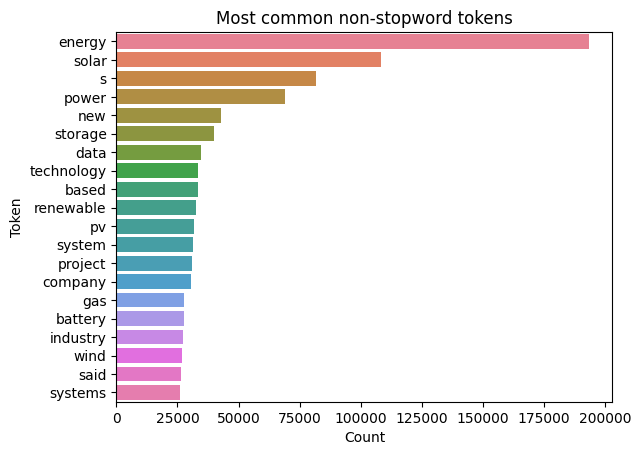

In [61]:
# Initializing the English NLP model and tokenizer
nlp = English()
tokenizer = nlp.tokenizer

# Tokenizing all articles and collecting tokens into a list
all_tokens = [token.text for article in articles_df["article"] for token in tokenizer(article)]

# Removing non-alphabetic tokens such as punctuation
alpha_tokens = [token for token in all_tokens if token.isalpha()]

# Converting all tokens to lowercase for uniformity
alpha_tokens = [token.lower() for token in alpha_tokens]

# Counting occurrences of each alphabetic token
alpha_token_counts = Counter(alpha_tokens)

# Removing stopwords such as 'the', 'a', 'and'
non_stop_tokens = [token for token in alpha_tokens if not nlp.vocab[token].is_stop]

# Counting occurrences of non-stopword tokens
non_stop_token_counts = Counter(non_stop_tokens)

# Creating a bar plot to visualize the most common non-stopword tokens
sns.barplot(
    x=[count for token, count in non_stop_token_counts.most_common(20)],
    y=[token for token, count in non_stop_token_counts.most_common(20)],
    hue=[token for token, count in non_stop_token_counts.most_common(20)]
)

# Setting the title and labels for the plot
plt.title("Most common non-stopword tokens")
plt.xlabel("Count")
plt.ylabel("Token")

# Displaying the plot
plt.show()

In [20]:
# Defining the path to the data folder
data_folder = Path('/content/drive/My Drive/Colab Notebooks/Final Project Updated')
# Creating a path for the silver folder within the data folder
silver_folder = data_folder / "silver"

# Checking if the silver folder does not exist
if not silver_folder.exists():
    # Creating the silver folder if it does not exist
    silver_folder.mkdir()

# Saving the articles DataFrame to a CSV file in the silver folder
# Using escapechar to handle special characters in the text
articles_df.to_csv(silver_folder / "articles.csv", index=False, escapechar='\\')

### Evaluation Data Set

In [64]:
# Displaying information about the human_eval_df DataFrame
human_eval_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 1 to 23
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question_id    23 non-null     int64 
 1   question       23 non-null     object
 2   relevant_text  23 non-null     object
 3   answer         23 non-null     object
 4   article_url    23 non-null     object
dtypes: int64(1), object(4)
memory usage: 1.1+ KB


In [65]:
# Renaming columns as needed for better understanding
human_eval_df.rename(columns={"relevant_text": "relevant_section", "article_url": "url"}, inplace=True)

# Dropping 'question_id' column
human_eval_df.drop(columns=["question_id"], inplace=True)

# Displaying the first few rows of the modified DataFrame to verify changes
human_eval_df.head()

,question,relevant_section,answer,url
example_id,,,,
1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,https://www.sgvoice.net/strategy/technology/23...
2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,https://www.sgvoice.net/policy/25396/eu-seeks-...
3,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,https://www.pv-magazine.com/2023/02/02/europea...
4,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,https://www.sgvoice.net/policy/25396/eu-seeks-...
5,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,https://cleantechnica.com/2023/05/08/general-m...


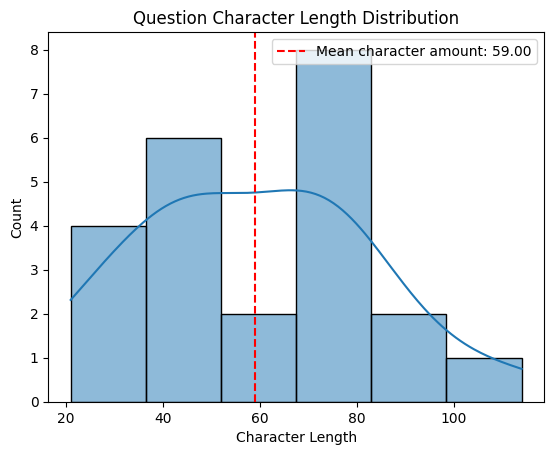

,question,relevant_section,answer,url
example_id,,,,
1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,sgvoice.net/strategy/technology/23971/leclanch...
2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,sgvoice.net/policy/25396/eu-seeks-competitive-...
4,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,sgvoice.net/policy/25396/eu-seeks-competitive-...
23,Which has the higher absorption coefficient fo...,We chose amorphous germanium instead of amorph...,amorphous germanium,pv-magazine.com/2021/01/15/germanium-based-sol...


In [66]:
# Creating a histogram to visualize the distribution of question character lengths
sns.histplot(human_eval_df["question"].map(len), kde=True)
plt.title("Question Character Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Count")

# Calculating and marking the mean character length on the histogram
mean_char_len = human_eval_df["question"].map(len).mean()
plt.axvline(mean_char_len, color='r', linestyle='--', label=f"Mean character amount: {mean_char_len:.2f}")
plt.legend()
plt.show()


# Defining a function to normalize URLs by removing protocol and www.
def normalize_url(url: str) -> str:
    url = url.replace("https://", "")
    url = url.replace("http://", "")
    url = url.replace("www.", "")
    url = url.rstrip("/")
    return url

# Normalizing URLs in both articles_df and human_eval_df to ensure consistency
articles_df["url"] = articles_df["url"].map(normalize_url)
human_eval_df["url"] = human_eval_df["url"].map(normalize_url)

# Identifying missing articles again after URL normalization
missing_articles = human_eval_df.copy()
missing_articles = missing_articles[~human_eval_df["url"].isin(articles_df["url"])]
missing_articles

In [67]:
# Replacing specific domain in missing articles' URLs for consistency
missing_articles["url"] = missing_articles["url"].map(lambda x: x.replace("sgvoice.net", "sgvoice.energyvoice.com"))

In [68]:
# Checking for any remaining missing articles that still do not match existing URLs
missing_articles[~missing_articles["url"].isin(articles_df["url"])]

,question,relevant_section,answer,url
example_id,,,,
23,Which has the higher absorption coefficient fo...,We chose amorphous germanium instead of amorph...,amorphous germanium,pv-magazine.com/2021/01/15/germanium-based-sol...


In [69]:
# Updating URLs in human_eval_df for those identified as missing articles
human_eval_df.loc[missing_articles.index, "url"] = missing_articles["url"]

# Displaying entries in human_eval_df where URLs match those in articles_df after updates
human_eval_df[human_eval_df["url"].isin(articles_df["url"])]

,question,relevant_section,answer,url
example_id,,,,
1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,sgvoice.energyvoice.com/strategy/technology/23...
2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,sgvoice.energyvoice.com/policy/25396/eu-seeks-...
3,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,pv-magazine.com/2023/02/02/european-commission...
4,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,sgvoice.energyvoice.com/policy/25396/eu-seeks-...
5,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,cleantechnica.com/2023/05/08/general-motors-se...
6,Did Colgate-Palmolive enter into PPA agreement...,"Scout Clean Energy, a Colorado-based renewable...",yes,solarindustrymag.com/scout-and-colgate-palmoli...
7,What is the status of ZeroAvia's hydrogen fuel...,"In December, the US startup ZeroAvia announced...",ZeroAvia's hydrogen fuel cell electric aircraf...,cleantechnica.com/2023/01/02/the-wait-for-hydr...
8,"What is the ""Danger Season""?",As spring turns to summer and the days warm up...,"The ""Danger Season"" is the period in the North...",cleantechnica.com/2023/05/15/what-does-a-norma...
9,Is Mississipi an anti-ESG state?,Mississippi is among two dozen or so states in...,yes,cleantechnica.com/2023/05/15/mississippi-takes...


## Subsampling



In [70]:
# Filtering articles with URLs in human_eval_df
eval_articles_df = articles_df[articles_df["url"].isin(human_eval_df["url"])]

# Displaying the first few rows of the filtered DataFrame
eval_articles_df.head()

,title,content,domain,url,article,lang
93950,Agrivoltaics Goes Nuclear On California Prairie,['A decommissioned nuclear power plant from th...,cleantechnica,cleantechnica.com/2022/12/18/agrivoltaics-goes...,A decommissioned nuclear power plant from the ...,en
93986,The Wait For Hydrogen Fuel Cell Electric Aircr...,['The US firm ZeroAvia is one step closer to b...,cleantechnica,cleantechnica.com/2023/01/02/the-wait-for-hydr...,The US firm ZeroAvia is one step closer to bri...,en
43308,Leclanché’ s new disruptive battery boosts ene...,['Energy storage company Leclanché ( SW.LECN) ...,energyvoice,sgvoice.energyvoice.com/strategy/technology/23...,Energy storage company Leclanché ( SW.LECN) ha...,en
21630,Quality Control System for Ocean Temperature I...,"[""By clicking `` Allow All '' you agree to the...",azocleantech,azocleantech.com/news.aspx?newsID=32873,"Over the last century, over 16 million ocean ...",en
98795,European Commission introduces Green Deal Indu...,['The European Commission listed tax exemption...,pv-magazine,pv-magazine.com/2023/02/02/european-commission...,"The European Commission listed tax exemptions,...",en


In [71]:
# Printing the number of unique URLs in eval_articles_df
print(eval_articles_df["url"].unique().shape)

# Printing the number of unique URLs in human_eval_df
print(human_eval_df["url"].unique().shape)

(20,)
(21,)


In [72]:
def do_stratification(
        df: pd.DataFrame,
        column: str,
        sample_size: int,
        seed: int = 55
) -> pd.DataFrame:
    # Creating a copy of the original DataFrame
    res_df = df.copy()

    # Sampling from each group in the specified column
    indx = df.groupby(column, group_keys=False)[column].apply(
        lambda x: x.sample(n=int(sample_size / len(df) * len(x)), random_state=seed)
    ).index.to_list()

    # Returning the stratified sample DataFrame
    return res_df.loc[indx]

In [73]:
# Creating a stratified sample of 1000 articles based on the 'domain' column
sample_df = do_stratification(articles_df, "domain", 1000, 69)

# Removing articles from the sample that are already in the evaluation set
sample_df = sample_df[~sample_df["url"].isin(eval_articles_df["url"])]

# Concatenating the filtered sample with the evaluation articles
sample_df = pd.concat([sample_df, eval_articles_df])

# Displaying information about the combined DataFrame
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 17313 to 63679
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1004 non-null   object
 1   content  1004 non-null   object
 2   domain   1004 non-null   object
 3   url      1004 non-null   object
 4   article  1004 non-null   object
 5   lang     1004 non-null   object
dtypes: object(6)
memory usage: 54.9+ KB


In [74]:
# Iterating through each entry in the 'content' column of sample_df
for index, row in sample_df.iterrows():
    # Getting the content from the current row
    content = row['content']

    # Removing line breaks from the content
    if isinstance(content, str):
        content = content.replace('\n', ' ')  # Replace line breaks with a space

    # Handling string representation of a list
    if isinstance(content, str):
        # Converting the string representation of a list into an actual list
        content_list = eval(content)  # Caution: Use eval only with trusted input
    else:
        content_list = content  # If it's already a list, keep it as is

    # Formatting content to display each item on a new line with quotes
    formatted_content = '[' + '\n\n'.join(f'{item}' for item in content_list) + ']'

    # Updating the DataFrame with the formatted content
    sample_df.at[index, 'content'] = formatted_content

# Printing the updated content to verify changes
print(sample_df['content'].head(1))

17313    [Change is sweeping the highways of the United...
Name: content, dtype: object


In [75]:
# Displaying information about the sample_df DataFrame
sample_df.info()

# Displaying the first few rows of the 'content' column
sample_df['content'].head()

# Saving the DataFrame to a CSV file
sample_df.to_csv('formatted_sample_df.csv', index=False)

# Printing information about the DataFrame again
print(sample_df.info())

# Printing the first few rows of the 'content' column to verify changes
print(sample_df['content'].head())

<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 17313 to 63679
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1004 non-null   object
 1   content  1004 non-null   object
 2   domain   1004 non-null   object
 3   url      1004 non-null   object
 4   article  1004 non-null   object
 5   lang     1004 non-null   object
dtypes: object(6)
memory usage: 87.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1004 entries, 17313 to 63679
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1004 non-null   object
 1   content  1004 non-null   object
 2   domain   1004 non-null   object
 3   url      1004 non-null   object
 4   article  1004 non-null   object
 5   lang     1004 non-null   object
dtypes: object(6)
memory usage: 87.2+ KB
None
17313    [Change is sweeping the highways of the United...
21746    [By clicking `` Allow All '' you agree to

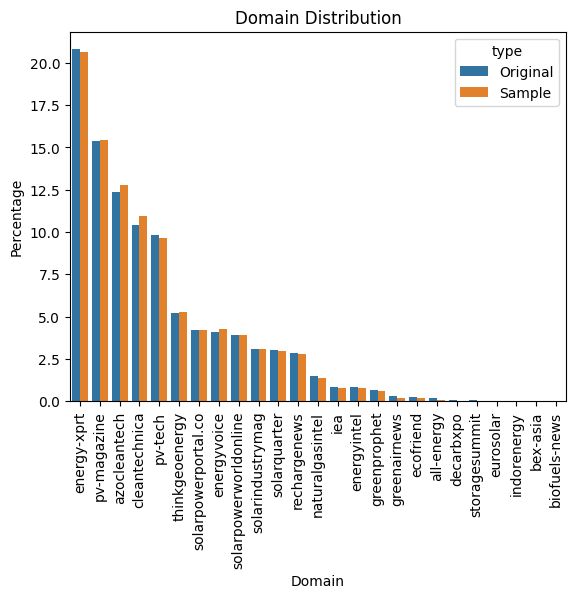

In [76]:
# Calculating the percentage of each domain in the original articles DataFrame
original_domain_counts = articles_df["domain"].value_counts().to_frame()
original_domain_counts = original_domain_counts / original_domain_counts.sum() * 100
domain_counts_df = original_domain_counts.copy()
domain_counts_df["type"] = "Original"

# Calculating the percentage of each domain in the sample DataFrame
sample_domain_counts = sample_df["domain"].value_counts().to_frame()
sample_domain_counts = sample_domain_counts / sample_domain_counts.sum() * 100
sample_domain_counts["type"] = "Sample"

# Concatenating original and sample domain counts into a single DataFrame
domain_counts_df = pd.concat([domain_counts_df, sample_domain_counts])

# Creating a bar plot to visualize domain distribution
sns.barplot(
    x=domain_counts_df.index,
    y=domain_counts_df["count"],
    hue=domain_counts_df["type"]
)

# Setting plot titles and labels
plt.title("Domain Distribution")
plt.xlabel("Domain")
plt.ylabel("Percentage")
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.show()

### Creating the Chunks

In this notebook we will be using two different chunking strategies:
- **Recursive Chunking:** This strategy involves recursively splitting the article into smaller chunks based on the article structure such as paragraphs and sentences until the chunk size is less than or equal to the maximum chunk size.
- **Semantic Chunking:** This strategy involves splitting the article into chunks based on semantic boundaries. This strategy finds boundaries between sentences that are semantically different and splits the article at these boundaries to create chunks. To do this we will need to use an embedding model to calculate the similarity between sentences. These embedding models will then also be used in the retrieval step to find the most relevant chunks.
- **NLTK Chunking:**

In [77]:
# Defining a function to create a recursive text splitter
def get_recursive_splitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
    return RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, # Setting the maximum size of each chunk
        chunk_overlap=chunk_overlap, # Setting the overlap between chunks
        separators=["\n\n", "\n", "(?<=\. )", " ", ""], # Defining separators for splitting
        length_function=len, # Using len() function to measure text length
    )

In [78]:
# Question b)
# Uing NLTK Splitter
from langchain.text_splitter import NLTKTextSplitter

# Defining a function to create an NLTK text splitter
def get_nltk_splitter(chunk_size: int, chunk_overlap: int) -> TextSplitter:
    return NLTKTextSplitter(
        chunk_size=chunk_size,  # Setting the maximum size of each chunk
        chunk_overlap=chunk_overlap,  # Setting the overlap between chunks
        separator=" ", # Defining separators for splitting
        length_function=len, # Using len() function to measure text length
    )

In [79]:
# Checking for newlines in the sample data
newline_counts = sample_df["article"].map(lambda x: x.count("\n") if isinstance(x, str) else 0).sum()
print(newline_counts)

0


Let us set the device for efficient use of available resources.

In [80]:
# Determining the best available device (CPU, CUDA, or MPS)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Setting up model parameters
model_kwargs = {'device': device, "trust_remote_code": True}
model_kwargs

{'device': 'cuda', 'trust_remote_code': True}

### Emdedding Models

In [138]:
# Defining embedding models
# Three embedding models used
embedding_models = {
    "mini": HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2", model_kwargs=model_kwargs),
    "bge-m3": HuggingFaceEmbeddings(model_name="BAAI/bge-m3", model_kwargs=model_kwargs),
    "gte": HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-base-en-v1.5", model_kwargs=model_kwargs),
}

In [139]:
# Defining sample input text to get embeddings
sample_text = ["This is a test sentence for getting the embeddings."]

# Defining a function to retrieve embedding size
def get_embedding_size(model):
    # Generating embeddings for the sample text
    embedding = model.embed_documents(sample_text)  # This returns a list of embeddings
    return len(embedding[0])  # Returning the size of the first embedding vector

# Getting and printing embedding sizes for all models
embedding_sizes = {}
for model_name, model in embedding_models.items():
    size = get_embedding_size(model)  # Retrieving embedding size
    embedding_sizes[model_name] = size  # Storing size in dictionary
    print(f"Embedding size for {model_name}: {size}")

# Outputting the sizes of embeddings for all models
print(embedding_sizes)

Embedding size for mini: 768
Embedding size for bge-m3: 1024
Embedding size for gte: 768
{'mini': 768, 'bge-m3': 1024, 'gte': 768}


### Chunking Strategies

In [140]:
# Creating recursive splitters with different chunk sizes
recursive_256_splitter = get_recursive_splitter(256, 64) # Chunk size: 256, overlap: 64
recursive_1024_splitter = get_recursive_splitter(1024, 128) # Chunk size: 1024, overlap: 128
# Creating a semantic splitter (chunk size determined by semantic boundaries)
semantic_splitter = SemanticChunker(
    embedding_models["mini"], breakpoint_threshold_type="percentile"
)

# CLearly mentioned that it splits based on full sentences
# Creating NLTK splitters with different chunk sizes
nltk_splitter_256_1 = get_nltk_splitter(chunk_size=256, chunk_overlap=64)  # Chunk size: 256, overlap: 64
nltk_splitter_1024 = get_nltk_splitter(chunk_size=1024, chunk_overlap=128)  # Chunk size: 1024, overlap: 128

# Creating a dictionary of splitters
splitters = {
    "recursive_256": recursive_256_splitter,
    "recursive_1024": recursive_1024_splitter,
    "semantic": semantic_splitter,
    "nltk_256_1": nltk_splitter_256_1,
    "nltk_1024": nltk_splitter_1024
}

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [141]:
# Defining a function to chunk documents
def chunk_documents(df: pd.DataFrame, text_splitter: TextSplitter):
    chunks = []  # Initializing a list to hold the document chunks
    id = 0  # Initializing a running ID for chunks
    for _, row in tqdm(df.iterrows(), total=len(df)):
        article_content = row['article']
        title = row['title']
        # Combining title and content as the title might be relevant to the question
        full_text = title + ": " + article_content
        char_chunks = text_splitter.split_text(full_text)  # Splitting the full text into chunks

        # Iterating over each chunk with its index
        for in_doc_chunk_id, chunk in enumerate(char_chunks):  # Using enumerate to get index
            id += 1  # Incrementing the chunk ID
            # Adding metadata to the chunk for potential later use
            metadata = {
                'title': row['title'],
                'url': row['url'],
                'domain': row['domain'],
                'id': id,  # Running ID for the chunk
                'in_document_chunk_id': in_doc_chunk_id  # New field for in-document chunk ID (0-based)
            }

            # Appending the chunk as a Document object to the list
            chunks.append(Document(
                page_content=chunk,
                metadata=metadata,
            ))
    return chunks  # Returning the list of document chunks

In [142]:
# Creating a folder for storing chunks
chunks_folder = silver_folder / "chunks5"

if not chunks_folder.exists():
    chunks_folder.mkdir()

In [143]:
# Defining a function to get or create chunks
def get_or_create_chunks(df: pd.DataFrame, text_splitter: TextSplitter, splitter_name: str) -> List[Document]:
    # Defining the path for the chunks file
    chunks_file = chunks_folder / f"{splitter_name}_chunks.json"

    # Checking if the chunks file already exists
    if chunks_file.exists():
        with open(chunks_file, "r") as file:
            # Loading chunks from the existing file
            chunks = [Document(**chunk) for chunk in json.load(file)]
        print(f"Loaded {len(chunks)} chunks from {chunks_file}")
    else:
        # Creating chunks if the file does not exist
        chunks = chunk_documents(df, text_splitter)
        with open(chunks_file, "w") as file:
            # Saving the created chunks to a JSON file
            json.dump([doc.dict() for doc in chunks], file, indent=4)
        print(f"Saved {len(chunks)} chunks to {chunks_file}")

    return chunks  # Returning the list of document chunks

In [144]:
# Creating/ Loading chunks for each splitter
chunks = {}
for splitter_name, splitter in splitters.items():
    # Getting or creating chunks for the current splitter
    chunks[splitter_name] = get_or_create_chunks(sample_df, splitter, splitter_name)

Loaded 26630 chunks from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/chunks5/recursive_256_chunks.json
Loaded 6018 chunks from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/chunks5/recursive_1024_chunks.json
Loaded 3293 chunks from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/chunks5/semantic_chunks.json
Loaded 25127 chunks from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/chunks5/nltk_256_1_chunks.json
Loaded 6059 chunks from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/chunks5/nltk_1024_chunks.json


### Analyzing the Chunks


In [88]:
# Printing the first chunk without using any splitter
first_chunk = sample_df['content'].iloc[0]  # Accessing the first entry in the 'content' column

# Printing the cleaned first chunk
print("First Chunk:")
print(first_chunk)

First Chunk:
[Change is sweeping the highways of the United Kingdom. Being responsible for 88% of passenger miles and 79% of freight traffic, England's highways are crucial. Aside from that, despite making up just 2% of roads, National Highways ' strategic road network ( SRN) handles one-third of passenger miles and two-thirds of freight miles in England. Connectivity is crucial for investment, community empowerment, and efficient domestic and international supply chains in the SRN.

As they glide past their diesel and gasoline-powered competitors, sleek electric cars ( EVs) are bringing with them the promise of a more environmentally friendly future. An important strategic change driving the UK's ambitious decarbonisation targets is the recent uptick in the popularity of electric vehicles.

In an effort to speed up the transition to electric vehicles, the UK government has enacted a number of regulations. According to a May 2019 report by the Committee on Climate Change ( CCC), in ord

In [145]:
# Printing the first chunk for each splitter type
for splitter_name, splitter_chunks in chunks.items():
    print(f"{splitter_name} chunks:")
    print(wrap_text(splitter_chunks[0].page_content, char_per_line=150))
    print()

recursive_256 chunks:
Charging Ahead: The UK’ s Electric Vehicle Revolution: Change is sweeping the highways of the United Kingdom. Being responsible for 88% of passenger
miles and 79% of freight traffic, England's highways are crucial. Aside from that, despite making up just

recursive_1024 chunks:
Charging Ahead: The UK’ s Electric Vehicle Revolution: Change is sweeping the highways of the United Kingdom. Being responsible for 88% of passenger
miles and 79% of freight traffic, England's highways are crucial. Aside from that, despite making up just 2% of roads, National Highways ' strategic
road network ( SRN) handles one-third of passenger miles and two-thirds of freight miles in England. Connectivity is crucial for investment,
community empowerment, and efficient domestic and international supply chains in the SRN. As they glide past their diesel and gasoline-powered
competitors, sleek electric cars ( EVs) are bringing with them the promise of a more environmentally friendly future.

In [146]:
# Defining a function to plot chunk lengths
def plot_chunk_lengths(chunks: List[Document], title: str):
    sns.histplot([len(chunk.page_content) for chunk in chunks], kde=True)
    plt.title(title)
    plt.xlabel("Chunk length")
    plt.ylabel("Number of chunks")
    median_chunk_len = np.median([len(chunk.page_content) for chunk in chunks])
    mean_chunk_len = np.mean([len(chunk.page_content) for chunk in chunks])
    plt.axvline(median_chunk_len, color='r', linestyle='--', label=f"Median chunk length: {median_chunk_len:.2f}")
    plt.axvline(mean_chunk_len, color='g', linestyle='--', label=f"Mean chunk length: {mean_chunk_len:.2f}")
    plt.legend()
    plt.show()

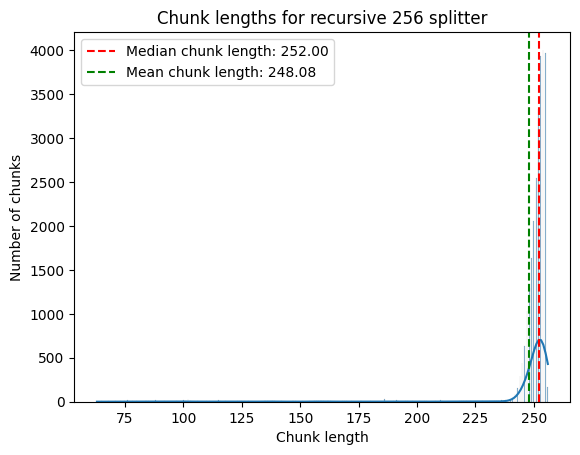

In [147]:
# Plotting chunk lengths for each splitter type
# Plotting for recursive_256 splitter
plot_chunk_lengths(chunks["recursive_256"], "Chunk lengths for recursive 256 splitter")

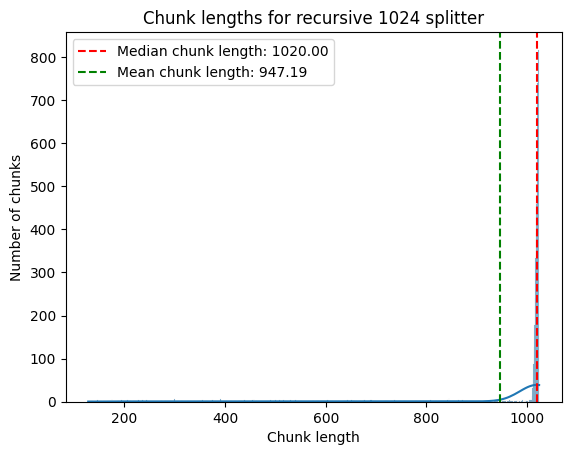

In [92]:
# Plotting for recursive_1024 splitter
plot_chunk_lengths(chunks["recursive_1024"], "Chunk lengths for recursive 1024 splitter")

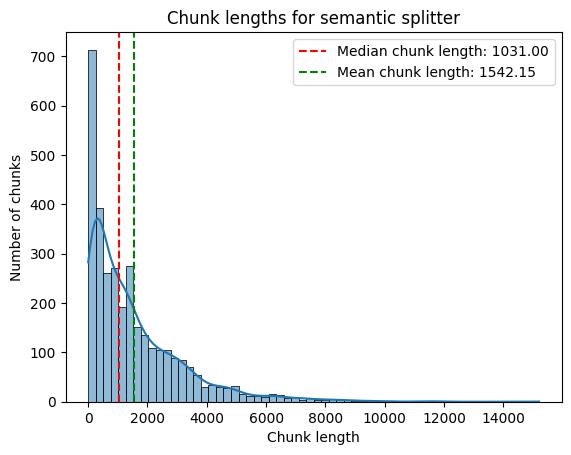

In [93]:
# Plotting for semantic splitter
plot_chunk_lengths(chunks["semantic"], "Chunk lengths for semantic splitter")

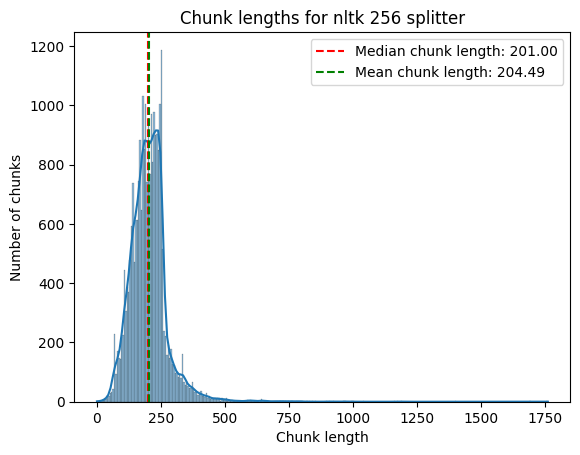

In [94]:
# Plotting chunk lengths for NLTK splitters
plot_chunk_lengths(chunks["nltk_256_1"], "Chunk lengths for nltk 256 splitter")

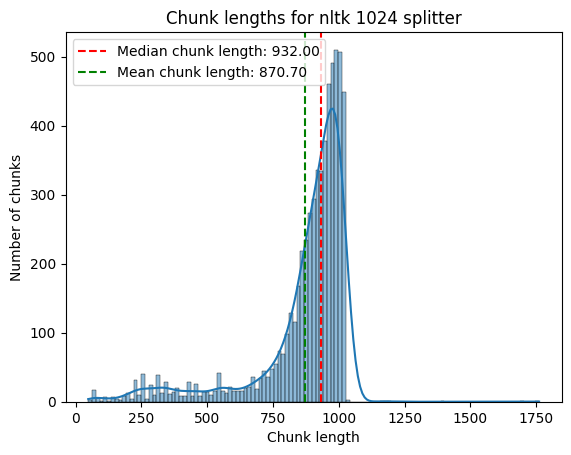

In [95]:
# Plotting chunk lengths for NLTK splitters
plot_chunk_lengths(chunks["nltk_1024"], "Chunk lengths for nltk 1024 splitter")

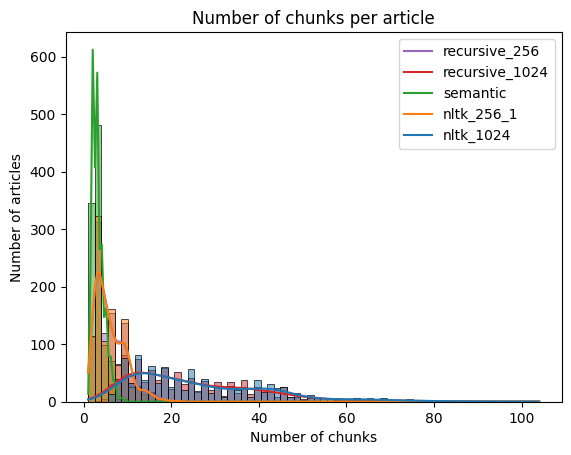

In [148]:
# Analyzing chunks per article
chunks_per_article = {splitter_name: Counter([chunk.metadata["title"] for chunk in chunks]) for splitter_name, chunks in chunks.items()}
counts = {splitter_name: [count for title, count in chunk_counts.items()] for splitter_name, chunk_counts in chunks_per_article.items()}

# Plotting the number of chunks per article
sns.histplot(counts, kde=True)
plt.title("Number of chunks per article")
plt.xlabel("Number of chunks")
plt.ylabel("Number of articles")
plt.legend(chunks_per_article.keys())
plt.show()

## Generating Embeddings


In [149]:
class CustomChromadbEmbeddingFunction(EmbeddingFunction):

    def __init__(self, model) -> None:
        super().__init__()  # Initializing the parent class
        self.model = model  # Storing the provided model

    def _embed(self, l):
        # Embedding each item in the list using the model
        return [self.model.embed_query(x) for x in l]

    def embed_query(self, query):
        # Embedding a single query by calling _embed
        return self._embed([query])

    def __call__(self, input: Documents) -> Embeddings:
        # Embedding a batch of documents and returning the embeddings
        embeddings = self._embed(input)
        return embeddings

In [150]:
# Creating a dictionary of custom embedding functions for different models
chroma_embedding_functions = {
    "mini": CustomChromadbEmbeddingFunction(embedding_models["mini"]),
    "bge-m3": CustomChromadbEmbeddingFunction(embedding_models["bge-m3"]),
    "gte": CustomChromadbEmbeddingFunction(embedding_models["gte"]),
}

# Iterating through each embedding function and generating a sample embedding
for name, embedding_function in chroma_embedding_functions.items():
    sample = embedding_function(["Hello, world!"])[0]  # Generating an embedding for the sample text
    print(f"{name} embedding sample: {sample}")  # Printing the generated embedding

# Do research on these three embeddings - find out how they are made and what their embedding lengths are
# Why author chose these three purposefully? ( purpose/ goal/ expectation)
# The difference may depend on embedding lenghts - May according to professor
# chroma is the vector store

mini embedding sample: [0.03492268547415733, 0.0188300758600235, -0.017854738980531693, 0.0001388332893839106, 0.07407363504171371, -0.022626394405961037, 0.003907608333975077, 0.0391995795071125, 0.03311211243271828, -0.014111754484474659, -0.02880692295730114, -0.0375986211001873, -0.032301995903253555, 0.025418760254979134, 0.0883222371339798, -0.07748755067586899, 0.06744017452001572, -0.010266427882015705, -0.04008452594280243, 0.009139195084571838, 0.011325545608997345, 0.007057399954646826, 0.01674513705074787, 0.055235859006643295, 0.01936730556190014, -0.027065206319093704, 0.031041482463479042, -0.0007472154684364796, 0.0249310489743948, 0.005939580500125885, -0.03344238921999931, 0.003518997924402356, 0.04953838884830475, 0.05694105848670006, 2.060878387055709e-06, -0.046322450041770935, 0.022610336542129517, -0.013061379082500935, -0.008191706612706184, -0.002991351066157222, -0.009296705015003681, 0.026914935559034348, -0.019516801461577415, 0.010469100438058376, 0.0029320

In [151]:
# Defining the path for the embeddings folder
embeddings_folder = silver_folder / "embeddings1"

# Checking if the embeddings folder does not exist
if not embeddings_folder.exists():
    embeddings_folder.mkdir()  # Creating the embeddings folder if it doesn't exist

In [152]:
class DocumentEmbedding:
    def __init__(self, document: Document, text_embedding: List[float]) -> None:
        self.document = document  # Storing the document
        self.text_embedding = text_embedding  # Storing the text embedding

    def to_dict(self) -> Dict:
        # Converting the DocumentEmbedding instance to a dictionary
        return {
            "document": self.document.dict(),
            "text_embedding": self.text_embedding
        }

    @classmethod
    def from_dict(cls, d: Dict) -> "DocumentEmbedding":
        # Creating a DocumentEmbedding instance from a dictionary
        return cls(
            document=Document(**d["document"]),
            text_embedding=d["text_embedding"]
        )


def get_or_create_embeddings(
        embedding_function: EmbeddingFunction,
        chunks: List[Document],
        embedding_name: str,
) -> List[DocumentEmbedding]:
    # Defining the path for the embeddings file
    embeddings_file = embeddings_folder / f"{embedding_name}_embeddings.json"

    # Checking if the embeddings file already exists
    if embeddings_file.exists():
        with open(embeddings_file, "r") as file:
            # Loading embeddings from the existing file
            embeddings = [DocumentEmbedding.from_dict(embedding) for embedding in json.load(file)]
        print(f"Loaded {len(embeddings)} embeddings from {embeddings_file}")
    else:
        embeddings = []  # Initializing an empty list for new embeddings
        for chunk in tqdm(chunks):
            # Generating embedding for each chunk using the embedding function
            text_embedding = embedding_function([chunk.page_content])[0]
            embedding = DocumentEmbedding(
                document=chunk,
                text_embedding=text_embedding
            )
            embeddings.append(embedding)  # Appending the new embedding to the list

        with open(embeddings_file, "w") as file:
            # Saving the generated embeddings to a JSON file
            json.dump([embedding.to_dict() for embedding in embeddings], file, indent=4)
        print(f"Saved {len(embeddings)} embeddings to {embeddings_file}")

    return embeddings  # Returning the list of DocumentEmbedding instances

In [153]:
# Initializing a dictionary to store embeddings
embeddings = {}

# Iterating through each embedding function in chroma_embedding_functions
for embedding_name, embedding_function in chroma_embedding_functions.items():
    # Iterating through each set of chunks for different splitters
    for splitter_name, splitter_chunks in chunks.items():
        # Getting or creating embeddings for the current embedding function and splitter chunks
        embeddings[f"{embedding_name}_{splitter_name}"] = get_or_create_embeddings(
            embedding_function, splitter_chunks, f"{embedding_name}_{splitter_name}"
        )

Loaded 26630 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/mini_recursive_256_embeddings.json
Loaded 6018 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/mini_recursive_1024_embeddings.json
Loaded 3293 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/mini_semantic_embeddings.json
Loaded 25127 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/mini_nltk_256_1_embeddings.json
Loaded 6059 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/mini_nltk_1024_embeddings.json
Loaded 26630 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/bge-m3_recursive_256_embeddings.json
Loaded 6018 embeddings from /content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1/bge-m3_recursive_1024_embeddings.

In [154]:
# The following code is to be used for re-runs.
# Instead of running the embeddings time to time, this chunk helps to retrive the stored content.
# Saving Computing units and time

# Defining paths for embeddings
# embeddings_folder = Path("/content/drive/My Drive/Colab Notebooks/Final Project Updated/silver/embeddings1")

# Function to load embeddings from a JSON file
# def load_embeddings(embedding_name: str) -> list:
#     embedding_file = embeddings_folder / f"{embedding_name}_embeddings.json"  # Constructing the file path
#     if embedding_file.exists():
#         with open(embedding_file, "r") as file:
#             embeddings = json.load(file)  # Loading embeddings from the JSON file
#         print(f"Loaded {len(embeddings)} embeddings from {embedding_file}")  # Printing the number of loaded embeddings
#         return embeddings
#     else:
#         print(f"Embeddings file {embedding_name} not found.")  # Handling case where the file does not exist
#         return []

# Loading all specified embeddings into a dictionary
# embeddings = {}
# embedding_names = [
#     "mini_recursive_256", "mini_recursive_1024", "mini_semantic",
#     "mini_nltk_256", "mini_nltk_1024", "bge-m3_recursive_256",
#     "bge-m3_recursive_1024", "bge-m3_semantic", "bge-m3_nltk_256",
#     "bge-m3_nltk_1024", "gte_recursive_256", "gte_recursive_1024",
#     "gte_semantic", "gte_nltk_256", "gte_nltk_1024"
# ]

# Iterating through each embedding name to load embeddings
# for name in embedding_names:
#     embeddings[name] = load_embeddings(name)  # Storing loaded embeddings in the dictionary


In [155]:
# Previewing the first 5 entries of "mini_recursive_256" for reference
print("Preview for mini_recursive_256:", embeddings["mini_recursive_256"][:5])  # Printing the first 5 embeddings

Preview for mini_recursive_256: [<__main__.DocumentEmbedding object at 0x790b54feac20>, <__main__.DocumentEmbedding object at 0x790952cb7700>, <__main__.DocumentEmbedding object at 0x790952cb76a0>, <__main__.DocumentEmbedding object at 0x790952cb5420>, <__main__.DocumentEmbedding object at 0x790952cb5540>]


The number of embeddings relates to the number of chunks produced by the individual chunking strategies, not the embedding dimensions. Thus smaller chunk size (e.g. 256) yields more chunks than larger chunk size (1024), and semantic embeddings even less chunks.

### Storing the Embeddings in ChromaDB


In [21]:
# Defining the path for the gold folder
gold_folder = data_folder / "gold"

# Checking if the gold folder does not exist
if not gold_folder.exists():
    gold_folder.mkdir()  # Creating the gold folder if it doesn't exist

# Defining the path for the chromadb folder within the gold folder
chromadb_folder = gold_folder / "chromadb"

# Checking if the chromadb folder does not exist
if not chromadb_folder.exists():
    chromadb_folder.mkdir()  # Creating the chromadb folder if it doesn't exist

# Initializing a PersistentClient for ChromaDB with the specified path
chroma_client = chromadb.PersistentClient(path=chromadb_folder.as_posix())

In [157]:
def get_or_create_collection(
        name: str,
        embedding_function: EmbeddingFunction,
        embeddings: List[DocumentEmbedding],
        batch_size: int = 128
) -> Collection:
    # Getting or creating a collection in ChromaDB with specified parameters
    collection = chroma_client.get_or_create_collection(
        name=name,
        # Configuring to use cosine distance instead of the default L2 distance
        metadata={"hnsw:space": "cosine"},
        embedding_function=embedding_function
    )

    # Checking if the collection is empty
    if collection.count() == 0:
        # Adding embeddings in batches to the collection
        for i in tqdm(range(0, len(embeddings), batch_size)):
            batch = embeddings[i:i + batch_size]  # Slicing the list into batches
            collection.add(
                documents=[embedding.document.page_content for embedding in batch],  # Extracting document contents
                embeddings=[embedding.text_embedding for embedding in batch],  # Extracting text embeddings
                ids=[str(embedding.document.metadata["id"]) for embedding in batch],  # Extracting IDs
                metadatas=[embedding.document.metadata for embedding in batch]  # Extracting metadata
            )

    return collection  # Returning the created or retrieved collection

In [158]:
# Initializing a dictionary to store collections
collections = {}

# Iterating through each collection name and its corresponding embeddings
for collection_name, current_embeddings in embeddings.items():
    # Getting or creating a collection in ChromaDB
    collection = get_or_create_collection(
        collection_name,
        chroma_embedding_functions[collection_name.split("_")[0]],  # Extracting the embedding function based on the name
        current_embeddings  # Passing the current embeddings for this collection
    )

    # Storing the created or retrieved collection in the collections dictionary
    collections[collection_name] = collection

    # Printing the number of documents in the current collection
    print(f"Collection {collection_name} has {collection.count()} documents")

Collection mini_recursive_256 has 26630 documents
Collection mini_recursive_1024 has 6018 documents
Collection mini_semantic has 3293 documents
Collection mini_nltk_256_1 has 25127 documents
Collection mini_nltk_1024 has 6059 documents
Collection bge-m3_recursive_256 has 26630 documents
Collection bge-m3_recursive_1024 has 6018 documents
Collection bge-m3_semantic has 3293 documents
Collection bge-m3_nltk_256_1 has 25127 documents
Collection bge-m3_nltk_1024 has 6059 documents
Collection gte_recursive_256 has 26630 documents
Collection gte_recursive_1024 has 6018 documents
Collection gte_semantic has 3293 documents
Collection gte_nltk_256_1 has 25127 documents
Collection gte_nltk_1024 has 6059 documents


In [160]:
# For testing and verification
# Selecting a specific collection from the collections dictionary
selected_collection = collections["gte_recursive_1024"]

# Querying the selected collection for documents related to "Climate Change"
results = selected_collection.query(
    query_texts=["Climate Change"],  # Specifying the query text
    n_results=3,  # Requesting the top 3 results
)

# Iterating through the retrieved documents and printing them
for doc in results["documents"][0]:
    print(wrap_text(doc))  # Formatting and printing the document content
    print()  # Printing an empty line for better readability

Global Weirding Archives - Page 3 of 22: Largely Unregulated Gas Pipelines Huge Source of Methane
Pollution The largest source of leaks of the potent greenhouse gas methane may be the spider...
From the hottest oceans on record to billions of dollars in climate-related disaster in 2021, here
are three short summaries of climate & cleantech... Deep waters in temperate climate lakes have
already lost almost 20 percent of their oxygen supply. Originally published on Nexus Media. By
Kaitlin Sullivan On a... Florida will spend a bunch of money to manage storm water without asking
why more frequent storms and rising sea levels are happening. Earlier this fall, or late summer,
Hurricane Ida devastated my state. I was left without power for almost a week, and during the
first... Drilling into the Greenland ice sheet, researchers reconstructed the jet stream's past.
When astronauts first went to space, it struck them that the atmosphere was this very thin crescent
on the horizon ( limb) of the 

### Analyzing the Embedding Space

In [162]:
def get_vectors_from_collection(collection: Collection):
    # Retrieving stored chunks from the collection, including documents, metadata, and embeddings
    stored_chunks = collection.get(include=["documents", "metadatas", "embeddings"])
    return np.array(stored_chunks["embeddings"])  # Returning embeddings as a numpy array

def get_vectors_by_domain(collection: Collection, domain: str):
    # Retrieving stored chunks from the collection
    stored_chunks = collection.get(include=["documents", "metadatas", "embeddings"])
    metadatas = stored_chunks["metadatas"]  # Extracting metadata
    # Finding indices of embeddings that match the specified domain
    indices = [str(metadata["id"]) for metadata in metadatas if metadata["domain"] == domain]
    return collection.get(include=["embeddings"], ids=indices)["embeddings"]  # Returning embeddings for the specified domain

def fit_umap(vectors: np.ndarray):
    # Fitting UMAP to the provided vectors for dimensionality reduction
    return umap.UMAP().fit(vectors)

def project_embeddings(embeddings, umap_transform):
    # Projecting embeddings into a lower-dimensional space using the fitted UMAP transform
    return umap_transform.transform(embeddings)

In [163]:
# Retrieving vectors from the selected collection
vectors = get_vectors_from_collection(selected_collection)

# Printing the original shape of the vectors
print(f"Original shape: {vectors.shape}")

# Fitting UMAP to the original vectors
umap_transform = fit_umap(vectors)

# Projecting the original vectors into a lower-dimensional space using UMAP
vectors_projections = project_embeddings(vectors, umap_transform)

# Printing the shape of the projected vectors
print(f"Projected shape: {vectors_projections.shape}")

Original shape: (6018, 768)
Projected shape: (6018, 2)


In [164]:
# Creating a scatter plot using the projected vectors
fig = px.scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1])

# Displaying the scatter plot
fig.show()

In [165]:
fig = go.Figure()
for domain in sample_df["domain"].unique():
    domain_vectors = get_vectors_by_domain(selected_collection, domain)
    domain_projections = project_embeddings(domain_vectors, umap_transform)
    fig.add_trace(go.Scatter(x=domain_projections[:, 0], y=domain_projections[:, 1], mode='markers', marker=dict(size=4), name=domain))

fig.show()

In [166]:
def plot_retrieval_results(
        query: str,
        selected_collection: Collection,
        n_results: int = 5
):
    vectors = get_vectors_from_collection(selected_collection)
    umap_transform = fit_umap(vectors)
    vectors_projections = project_embeddings(vectors, umap_transform)

    query_embedding = selected_collection._embedding_function([query])[0]
    query_embedding = np.array(query_embedding).reshape(1, -1)
    query_projection = project_embeddings(query_embedding, umap_transform)

    nearest_neighbors = selected_collection.query(
        query_texts=[query],
        n_results=n_results,
    )
    neighbor_vectors = selected_collection.get(include=["embeddings"], ids=nearest_neighbors["ids"][0])["embeddings"]
    neighbor_projections = project_embeddings(neighbor_vectors, umap_transform)


    fig = go.Figure()

    fig.add_trace(go.Scatter(x=vectors_projections[:, 0], y=vectors_projections[:, 1], mode='markers', marker=dict(size=5), name="other vectors"))
    fig.add_trace(go.Scatter(x=neighbor_projections[:, 0], y=neighbor_projections[:, 1], mode='markers', marker=dict(size=5, color='orange'), name="nearest neighbors"))
    fig.add_trace(go.Scatter(x=query_projection[:, 0], y=query_projection[:, 1], mode='markers', marker=dict(size=10, color='red', symbol='x'), name="query"))

    fig.show()

# Plotting retrieval results for the query "Climate Change" from the selected collection
plot_retrieval_results(
    "Climate Change",  # The query text
    selected_collection  # The collection to search within
)

In [115]:
# Defining a function to calculate cosine distance between two vectors
def cosine_distance(vector1, vector2):
    dot_product = np.dot(vector1, vector2.T)  # Calculating the dot product
    norm_product = np.linalg.norm(vector1) * np.linalg.norm(vector2)  # Calculating the product of norms
    similarity = dot_product / norm_product  # Calculating cosine similarity
    return 1 - similarity  # Returning cosine distance

# Defining a function to plot cosine distances for a query against a collection
def plot_cosine_distances(
        query: str,  # The query string
        selected_collection: Collection  # The collection to search within
):
    # Retrieving vectors from the selected collection
    vectors = get_vectors_from_collection(selected_collection)

    # Fitting UMAP to the vectors for dimensionality reduction
    umap_transform = fit_umap(vectors)

    # Projecting the original vectors into a lower-dimensional space
    vectors_projections = project_embeddings(vectors, umap_transform)

    # Generating the embedding for the query
    query_embedding = selected_collection._embedding_function([query])[0]
    query_embedding = np.array(query_embedding).reshape(1, -1)  # Reshaping for consistency

    # Projecting the query embedding into the lower-dimensional space
    query_projection = project_embeddings(query_embedding, umap_transform)

    # Calculating cosine distances from the query embedding to all other vectors
    similarities = np.array([cosine_distance(query_embedding, vector) for vector in vectors])

    # Creating a scatter plot figure
    fig = go.Figure()

    # Adding a trace for other vectors with color based on cosine distances
    fig.add_trace(go.Scatter(
        x=vectors_projections[:, 0],  # X-coordinates from projected vectors
        y=vectors_projections[:, 1],  # Y-coordinates from projected vectors
        mode='markers',  # Setting mode to markers for scatter plot
        marker=dict(
            size=5,  # Marker size
            color=similarities.flatten(),  # Color based on cosine distances
            colorscale='RdBu',  # Color scale for visualization
            colorbar=dict(title='Cosine Distance')  # Adding a color bar with title
        ),
        text=['Cosine Distance: {:.4f}'.format(sim) for sim in similarities.flatten()],  # Tooltip text showing distances
        name='Other Vectors'  # Name for legend entry
    ))

    # Adding a trace for the query vector with distinct styling
    fig.add_trace(go.Scatter(
        x=[query_projection[0][0]],
        y=[query_projection[0][1]],
        mode='markers',
        marker=dict(size=10, color='black', symbol='x'),
        text=['Query Vector'],
        name='Query Vector'  # Name for legend entry of the query vector
    ))

    # Displaying the figure with all traces added
    fig.show()

In [116]:
# Plotting cosine distances for the query "Climate Change" from the selected collection
plot_cosine_distances(
    "Climate Change",  # The query string for which to calculate and visualize cosine distances
    selected_collection  # The collection to search within
)

### Putting it all Together


In [167]:
def create_qa_chain(retriever: BaseRetriever):
    # Defining a template for the question-answering task
    template = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. \
    If you don't know the answer, just say that you don't know. Keep the answer concise.

    Question: {question}
    Context: {context}
    Answer:
    """

    # Creating a prompt template from the defined string
    rag_prompt = ChatPromptTemplate.from_template(template)

    # Defining a function to format retrieved documents into a single string
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)  # Joining document contents with double newlines

    # Setting up a parallel runnable chain for retrieval and processing
    rag_chain = RunnableParallel(
        {
            "context": retriever,  # Assigning the retriever to get context
            "question": RunnablePassthrough()  # Passing through the question as is
        }
    ).assign(answer=(
         RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))  # Formatting context documents
            | rag_prompt  # Applying the prompt template to the formatted context and question
            | llm  # Passing the result to a language model for generating an answer
            | StrOutputParser()  # Parsing the output into a string format
    ))

    return rag_chain  # Returning the constructed question-answering chain

In [168]:
def collection_to_store(collection_name: str, lc_embedding_model: EmbeddingFunction):
    # Creating a Chroma vector store to store embeddings
    return Chroma(
        client=chroma_client,  # Using the existing Chroma client
        collection_name=collection_name,  # Specifying the name of the collection
        embedding_function=lc_embedding_model,  # Setting the embedding function for the collection
    )

def store_to_retriever(store: VectorStore, k: int = 3):
    # Converting the vector store into a retriever with specified search parameters
    retriever = store.as_retriever(
        search_type="similarity",  # Setting the search type to similarity
        search_kwargs={'k': k}  # Specifying the number of nearest neighbors to retrieve
    )
    return retriever  # Returning the configured retriever
# Question g) # k=1 and k=5 are implemented in the following code

In [169]:
# Creating a vector store for the specified collection using the GTE embedding model
selected_store = collection_to_store("gte_recursive_1024", embedding_models["gte"])

# Converting the vector store into a retriever for similarity searches
selected_retriever = store_to_retriever(selected_store)

# Invoking the retriever with a query about "Climate Change"
selected_retriever.invoke("Climate Change")

[Document(metadata={'domain': 'cleantechnica', 'id': 946, 'in_document_chunk_id': 0, 'title': 'Global Weirding Archives - Page 3 of 22', 'url': 'cleantechnica.com/tag/global-weirding/page/3'}, page_content="Global Weirding Archives - Page 3 of 22: Largely Unregulated Gas Pipelines Huge Source of Methane Pollution The largest source of leaks of the potent greenhouse gas methane may be the spider... From the hottest oceans on record to billions of dollars in climate-related disaster in 2021, here are three short summaries of climate & cleantech... Deep waters in temperate climate lakes have already lost almost 20 percent of their oxygen supply. Originally published on Nexus Media. By Kaitlin Sullivan On a... Florida will spend a bunch of money to manage storm water without asking why more frequent storms and rising sea levels are happening. Earlier this fall, or late summer, Hurricane Ida devastated my state. I was left without power for almost a week, and during the first... Drilling in

In [170]:
# Creating a question-answering chain using the selected retriever
selected_chain = create_qa_chain(selected_retriever)

# Invoking the QA chain with a specific question about wildfire smoke exposure
selected_chain.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'domain': 'cleantechnica', 'id': 5990, 'in_document_chunk_id': 7, 'title': 'What Does A “ Normal ” Year Of Wildfires Look Like In a Changing Climate?', 'url': 'cleantechnica.com/2023/05/15/what-does-a-normal-year-of-wildfires-look-like-in-a-changing-climate'}, page_content='Blue River, Vida, Phoenix, and Talent—were lost to the so-called Labor Day Fires in 2020. And in 2021, the Lytton Creek Fire wiped out the village of Lytton, British Columbia, destroying hundreds of homes. All told, between 2017 and 2021, nearly 120,000 fires burned across western North America, burning nearly 39 million acres of land and claiming more than 60,000 structures. The impacts of wildfires reach well beyond the people, communities, and ecosystems that are directly affected by flames. Wildfires have consequences for public health, water supplies, and economies long after a fire is extinguished. Mounting research is showing exposure to the fine particulate matter in wildfire 

In [121]:
# Question f) Trying two additional prompts
def create_qa_chain2(retriever: BaseRetriever):
    template = """You are a helpful assistant that extracts insights from the retrieved context to answer the user's question.
    Your task is to summarize the key points from the context and provide the most insightful and relevant answer.

    Question: {question}
    Context: {context}
    Instructions:
    - Provide a brief summary of the context that is most relevant to answering the question.
    - Focus on key insights and avoid irrelevant or detailed explanations.
    - Keep the answer concise but comprehensive.
    - If the context doesn’t provide a clear answer, say "I don't know."

    Answer:
    """
    rag_prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough()
        }
    ).assign(answer=(
         RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
            | rag_prompt
            | llm
            | StrOutputParser()
    ))

    return rag_chain

selected_chain2 = create_qa_chain2(selected_retriever)
selected_chain2.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'domain': 'cleantechnica', 'id': 5990, 'in_document_chunk_id': 7, 'title': 'What Does A “ Normal ” Year Of Wildfires Look Like In a Changing Climate?', 'url': 'cleantechnica.com/2023/05/15/what-does-a-normal-year-of-wildfires-look-like-in-a-changing-climate'}, page_content='Blue River, Vida, Phoenix, and Talent—were lost to the so-called Labor Day Fires in 2020. And in 2021, the Lytton Creek Fire wiped out the village of Lytton, British Columbia, destroying hundreds of homes. All told, between 2017 and 2021, nearly 120,000 fires burned across western North America, burning nearly 39 million acres of land and claiming more than 60,000 structures. The impacts of wildfires reach well beyond the people, communities, and ecosystems that are directly affected by flames. Wildfires have consequences for public health, water supplies, and economies long after a fire is extinguished. Mounting research is showing exposure to the fine particulate matter in wildfire 

In [122]:
def create_qa_chain3(retriever: BaseRetriever):
    template = """You are an assistant that answers questions based on context retrieved from multiple sources.
    Some of the context may be outdated or irrelevant. Your goal is to use the most recent and relevant information to answer the question.

    Question: {question}
    Context: {context}
    Instructions:
    - Prioritize the most recent and relevant information.
    - Ignore outdated or irrelevant context that does not help answer the question.
    - Provide a concise answer with a focus on the current or most up-to-date knowledge.
    - If the answer is not available in the context, say "I don't know."

    Answer:
    """
    rag_prompt = ChatPromptTemplate.from_template(template)

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = RunnableParallel(
        {
            "context": retriever,
            "question": RunnablePassthrough()
        }
    ).assign(answer=(
         RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
            | rag_prompt
            | llm
            | StrOutputParser()
    ))

    return rag_chain

selected_chain3 = create_qa_chain3(selected_retriever)
selected_chain3.invoke("Where are the biggest increases in wildfire smoke exposure in recent years?")

{'context': [Document(metadata={'domain': 'cleantechnica', 'id': 5990, 'in_document_chunk_id': 7, 'title': 'What Does A “ Normal ” Year Of Wildfires Look Like In a Changing Climate?', 'url': 'cleantechnica.com/2023/05/15/what-does-a-normal-year-of-wildfires-look-like-in-a-changing-climate'}, page_content='Blue River, Vida, Phoenix, and Talent—were lost to the so-called Labor Day Fires in 2020. And in 2021, the Lytton Creek Fire wiped out the village of Lytton, British Columbia, destroying hundreds of homes. All told, between 2017 and 2021, nearly 120,000 fires burned across western North America, burning nearly 39 million acres of land and claiming more than 60,000 structures. The impacts of wildfires reach well beyond the people, communities, and ecosystems that are directly affected by flames. Wildfires have consequences for public health, water supplies, and economies long after a fire is extinguished. Mounting research is showing exposure to the fine particulate matter in wildfire 

In [171]:
# Initializing an empty dictionary to store the QA chains
chains = {}

# Question f)
# Defining the values of k to experiment with for retrieval
k_values = [1, 3, 5]  # These represent the number of nearest neighbors to retrieve

# Iterating through each collection in the collections dictionary
for collection_name, collection in collections.items():
    # Creating a vector store for the current collection using the appropriate embedding model
    store = collection_to_store(collection_name, embedding_models[collection_name.split("_")[0]])

    # Creating a chain for each value of k specified in k_values
    for k in k_values:
        # Converting the vector store into a retriever configured for similarity searches
        retriever = store_to_retriever(store, k)  # Pass k to specify how many neighbors to retrieve

        # Creating a question-answering chain using the retriever
        chain = create_qa_chain(retriever)

        # Constructing a unique key for each combination of collection name and k value
        chain_key = f"{collection_name}_k{k}"

        # Storing the created chain in the chains dictionary with the unique key
        chains[chain_key] = chain

# Displaying the keys of the chains dictionary to see all created chains
chains.keys()

dict_keys(['mini_recursive_256_k1', 'mini_recursive_256_k3', 'mini_recursive_256_k5', 'mini_recursive_1024_k1', 'mini_recursive_1024_k3', 'mini_recursive_1024_k5', 'mini_semantic_k1', 'mini_semantic_k3', 'mini_semantic_k5', 'mini_nltk_256_1_k1', 'mini_nltk_256_1_k3', 'mini_nltk_256_1_k5', 'mini_nltk_1024_k1', 'mini_nltk_1024_k3', 'mini_nltk_1024_k5', 'bge-m3_recursive_256_k1', 'bge-m3_recursive_256_k3', 'bge-m3_recursive_256_k5', 'bge-m3_recursive_1024_k1', 'bge-m3_recursive_1024_k3', 'bge-m3_recursive_1024_k5', 'bge-m3_semantic_k1', 'bge-m3_semantic_k3', 'bge-m3_semantic_k5', 'bge-m3_nltk_256_1_k1', 'bge-m3_nltk_256_1_k3', 'bge-m3_nltk_256_1_k5', 'bge-m3_nltk_1024_k1', 'bge-m3_nltk_1024_k3', 'bge-m3_nltk_1024_k5', 'gte_recursive_256_k1', 'gte_recursive_256_k3', 'gte_recursive_256_k5', 'gte_recursive_1024_k1', 'gte_recursive_1024_k3', 'gte_recursive_1024_k5', 'gte_semantic_k1', 'gte_semantic_k3', 'gte_semantic_k5', 'gte_nltk_256_1_k1', 'gte_nltk_256_1_k3', 'gte_nltk_256_1_k5', 'gte_nlt

### Evaluation Set
#### Generating Synthetic QA Pairs


In [124]:
# Evaluation
human_eval_df.head()

,question,relevant_section,answer,url
example_id,,,,
1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,sgvoice.energyvoice.com/strategy/technology/23...
2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,sgvoice.energyvoice.com/policy/25396/eu-seeks-...
3,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,pv-magazine.com/2023/02/02/european-commission...
4,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,sgvoice.energyvoice.com/policy/25396/eu-seeks-...
5,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,cleantechnica.com/2023/05/08/general-motors-se...


In [125]:
# This is where the problem started, I named the ground_truth as answers which resulted in NA and the whole evaluation process was costed

def generate_eval_answers(df: pd.DataFrame) -> pd.DataFrame:
    answer_geneation_prompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
    answer_generation_chain = ChatPromptTemplate.from_template(answer_geneation_prompt) | llm
    for i, row in tqdm(df.iterrows(), total=len(df)):
        df.at[i, "ground_truth"] = answer_generation_chain.invoke({"question": row["question"], "article": row["relevant_section"]}).content
    return df

In [126]:
if (silver_folder / "human_eval.csv").exists():
    human_eval_df = pd.read_csv(silver_folder / "human_eval.csv")
else:
    human_eval_df = generate_eval_answers(human_eval_df)
    human_eval_df.to_csv(silver_folder / "human_eval.csv", index=False)

human_eval_df.head()


,question,relevant_section,answer,url,ground_truth
0,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,sgvoice.energyvoice.com/strategy/technology/23...,The innovation behind Leclanché's new method t...
1,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,sgvoice.energyvoice.com/policy/25396/eu-seeks-...,The EU's Green Deal Industrial Plan is a strat...
2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,pv-magazine.com/2023/02/02/european-commission...,The EU's Green Deal Industrial Plan aims to cr...
3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,sgvoice.energyvoice.com/policy/25396/eu-seeks-...,The four focus areas of the EU's Green Deal In...
4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,cleantechnica.com/2023/05/08/general-motors-se...,The cooperation between GM and Honda on fuel c...


In [127]:
def generate_synthetic_qa_pairs(documents: List[Document], n: int = 10) -> List[str]:
    synthetic_questions = []
    documents = np.random.choice(documents, n)

    question_generation_prompt = """Generate a short and general question based on the following news article:
    Article: {article}
    """
    question_generation_chain = ChatPromptTemplate.from_template(question_generation_prompt) | llm

    answer_geneation_prompt = """Answer the following question based on the article:
    Question: {question}
    Article: {article}
    """
    answer_generation_chain = ChatPromptTemplate.from_template(answer_geneation_prompt) | llm


    for document in tqdm(documents):
        element = {}
        content = document.page_content
        element["relevant_text"] = content
        element["url"] = document.metadata["url"]
        question = question_generation_chain.invoke({"article": content}).content
        element["question"] = question
        answer = answer_generation_chain.invoke({"question": question, "article": content}).content
        element["ground_truth"] = answer
        synthetic_questions.append(element)

    return pd.DataFrame(synthetic_questions)

In [128]:
if not (silver_folder / "synthetic_eval.csv").exists():
    synthetic_eval_df = generate_synthetic_qa_pairs(chunks["recursive_1024"], 25)
    synthetic_eval_df.to_csv(silver_folder / "synthetic_eval.csv", index=False)
else:
    synthetic_eval_df = pd.read_csv(silver_folder / "synthetic_eval.csv", index_col=0)
synthetic_eval_df.head()

,url,question,ground_truth
relevant_section,,,
"with the City of Detroit, is proud to announce the launch of an ambitious solar energy project that promises to shine groundbreaking light on combining urban agriculture and renewable energy. This groundbreaking initiative, aptly named “ Locally-Sited Utility-Scale Solar, ” marks the beginning of a multi-phase endeavor aimed at intertwining the growth of solar energy infrastructure with sustainable agricultural development in partnership with Detroit’ s vibrant communities. Lightstar would like to extend heartfelt gratitude to Mayor Mike Duggan, the City of Detroit, and the vibrant communities of State Fair and Gratiot-Findlay. Your unwavering support and enthusiasm are pivotal as we advance Phase I of our groundbreaking agrivoltaic solar installation project. Lightstar is honored to continue your work to date, promoting environmental justice and ensuring that the benefits of our projects are accessible to all. We are committed to transparent communication and ongoing collaboration and engagement with",cleantechnica.com/2024/06/25/solar-neighborhoo...,"What is the goal of the ""Locally-Sited Utility...","The goal of the ""Locally-Sited Utility-Scale S..."
"voltage and overload cut... By Lento Industries Pvt. Ltd based in Shakarpur, INDIA. from Solar Hybrid Domestic Inverter Product line , pump protection functions and battery charged state. The removable battery enables you to work uninterrupted. There are no control wires in the hand valve, therefore the sprayer is less prone to faults and the accessories can be used to their full... By Agralan Ltd. based in Wiltshire, UNITED KINGDOM. The CELLGUARD™ Wireless Battery Monitoring System ( BMS) provides an accurate and reliable indication of battery state-of-health through monitoring and analysis of battery voltage, temperature, and conductance.... By Franklin Electric Grid Solutions based in Madison, WISCONSIN ( USA). from Battery Monitoring Product line The SmartShunt is an all in one battery monitor, only without a display. Your phone acts as the display. The SmartShunt connects via Bluetooth to the VictronConnect App on your phone ( or tablet) and you can conveniently read out all monitored battery",energy-xprt.com/energy-storage/battery-energy-...,How can battery monitoring systems improve the...,Battery monitoring systems can improve the eff...
"rigs exit week/week, while California and Oklahoma each posted one-rig declines for the period, the BKR numbers show. Citing robust demand and fading pandemic worries, policymakers from the Organization of the Petroleum Exporting Countries ( OPEC), headed by Saudi Arabia, and a Russia-led group of allies known as OPEC-plus, said recently that they aim to boost output by 400,000 b/d next month. The effort would continue a targeted rate of monthly supply increases the cartel began in August to gradually unwind production cuts of nearly 10 million b/d made in April 2020 amid the initial demand destruction imposed by the coronavirus. Rystad Energy analyst Bjørnar Tonhaugen said American producers and others outside of OPEC-plus also are likely to raise output this year to meet demand and capitalize on favorable prices. “ Prices are far-far above breakeven…from anywhere from the U.S. shale patch to offshore, not to mention onshore fields in the Middle East, ” Tonhaugen said. “ From an operator’ s economical",naturalgasintel.com/natural-gas-drilling-rises...,How is the recent increase in oil production b...,The recent increase in oil production by OPEC ...
"SEIA: U.S. Solar Market Had Best First Quarter Ever: According to the U.S. Solar Market Insight Q2 2023 report by the Solar Energy Industries Association ( SEIA) and Wood Mackenzie, the U.S. solar industry just experienced its best first quarter ever, with 6.1 GW of solar capacity installed. Supply chain challenges abating and delayed solar projects resuming largely drove the record quarter. Due in part to the strong first quarter numbers

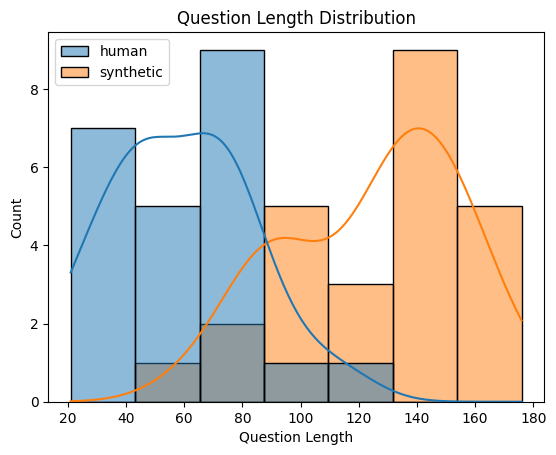

In [129]:
question_length = {
    "human": human_eval_df["question"].map(len),
    "synthetic": synthetic_eval_df["question"].map(len)
}

sns.histplot(question_length, kde=True)
plt.title("Question Length Distribution")
plt.xlabel("Question Length")
plt.ylabel("Count")
plt.show()

In [130]:
eval_df = pd.concat([human_eval_df, synthetic_eval_df], ignore_index=True)
eval_df["is_synthetic"] = eval_df["relevant_section"].isna()
eval_df["is_synthetic"].value_counts()

,count
is_synthetic,
True,25
False,23


Now we have doubled the number of questions and answers. However, we can see that our synthetic questions are slightly longer than the provided questions which could mean that they are slightly easier to answer. This potential bias should be taken into account when evaluating the pipeline.

### RAGAS Metrics


In [22]:
# Defining the path for the datasets folder
datasets_folder = gold_folder / "datasets"
# Checking if the datasets folder exists; if not, creating it.
if not datasets_folder.exists():
    datasets_folder.mkdir()

def get_or_create_eval_dataset(name: str, df: pd.DataFrame, chain: Chain, k: int) -> Dataset:
    # Constructing the path for the dataset file using the provided name and k value.
    # The filename will include the name and a suffix based on k.
    dataset_file = datasets_folder/ f"{name}_dataset.json"
    # dataset_file = datasets_folder / f"{name}_k{k}_dataset.json"  # Updated to include k
    # Checking if the dataset file already exists
    if dataset_file.exists():
        # Loading the dataset from JSON format into a Dataset object
        with open(dataset_file, "r") as file:
            dataset = Dataset.from_dict(json.load(file))
        print(f"Loaded {name} dataset from {dataset_file}")
    else:
        # If the file does not exist, preparing to create a new dataset
        datapoints = {
            "question": df["question"].tolist(),
            "answer": [],
            "contexts": [],
            "ground_truth": df["ground_truth"].tolist(),
            "context_urls": []
        }
        # Iterating through each question in the datapoints dictionary with progress tracking using tqdm.
        for question in tqdm(datapoints["question"]):
            result = chain.invoke(question)
            datapoints["answer"].append(result["answer"])
            datapoints["contexts"].append([str(doc.page_content) for doc in result["context"]])
            datapoints["context_urls"].append([doc.metadata["url"] for doc in result["context"]])
        # Creating a Dataset object from the prepared datapoints dictionary
        dataset = Dataset.from_dict(datapoints)
        # Opening a new file in write mode to save the newly created dataset in JSON format
        with open(dataset_file, "w") as file:
            json.dump(dataset.to_dict(), file)
        print(f"Saved {name} dataset to {dataset_file}")
    return dataset

In [24]:
# Importing again due to dependencies
from ragas import RunConfig, evaluate
# Defining the path for the results folder by combining gold_folder with "results".
results_folder = gold_folder / "results"
# Checking if the results folder exists; if not, creating it
if not results_folder.exists():
    results_folder.mkdir()

def get_or_run_llm_eval(name: str, dataset: Dataset, llm_judge_model: LLM) -> pd.DataFrame:
    # Constructing the path for the evaluation results file using the provided name and k value.
    # The filename will include the name and a suffix based on k.
    # eval_results_file = results_folder / f"{name}_llm_eval_results.csv"
    eval_results_file = results_folder / f"{name}_k{int(name.split('_k')[-1])}_llm_eval_results.csv"  # Includes k
     # Checking if the evaluation results file already exists
    if eval_results_file.exists():
        # If the file exists, loading the evaluation results from the CSV file into a DataFrame
        eval_results = pd.read_csv(eval_results_file)
        print(f"Loaded {name} evaluation results from {eval_results_file}")
    else:
        # Extracting k and embedding model name from 'name'
        embedding_model_name = name.split('_')[0]
        # Evaluating the dataset using the specified metrics and model
        eval_results = evaluate(dataset,
                                metrics=[faithfulness, answer_relevancy, context_relevancy, answer_correctness],
                                is_async=True,
                                llm=llm_judge_model,
                                embeddings=embedding_models[embedding_model_name],  # Use dynamic embedding model,
                                run_config=RunConfig(
                                    timeout=60, max_retries=10, max_wait=60, max_workers=8),
                                ).to_pandas()
        eval_results.to_csv(eval_results_file, index=False)
        print(f"Saved {name} evaluation results to {eval_results_file}")
    return eval_results

In [25]:
# Creating a function to plot LLM evaluation results using seaborn and matplotlib
def plot_llm_eval(name: str, eval_results: pd.DataFrame, k: int = None):
    # Selecting only the float64 columns (assuming these are the RAGAS metrics)
    ragas_metrics_data = (eval_results
                        .select_dtypes(include=[np.float64]))

    # Boxplot of mean
    # Creating a boxplot for distributions of RAGAS metrics
    sns.boxplot(data=ragas_metrics_data, palette="Set2")
    plt.title(f'{name} (k={k}): Distribution of RAGAS Evaluation Metrics' if k is not None else f'{name}: Distribution of RAGAS Evaluation Metrics')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n-------------------------------------------------------------------------------------------------------------------\n")

    # Barplot of means
    # Calculating mean scores of selected metrics
    means = ragas_metrics_data.mean()
    plt.figure(figsize=(14, 8))
    sns.barplot(x=means.index, y=means, palette="Set2")
    plt.title(f'{name} (k={k}): Mean of RAGAS Evaluation Metrics' if k is not None else f'{name}: Mean of RAGAS Evaluation Metrics')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [27]:
# Creating a function to plot multiple evaluations together
def plot_multiple_evals(eval_results: Dict[str, pd.DataFrame], k: int = None):
    # combine the results
    full_results = []
    for name, results in eval_results.items():
        # Adding model name as a column in results DataFrame
        results['name'] = name
        full_results.append(results)

    # Combining all results into a single DataFrame
    full_results = pd.concat(full_results, ignore_index=True)
    # Sorting combined DataFrame by model name
    full_results = full_results.sort_values(by='name')

    # Selecting only float64 columns (RAGAS metrics)
    ragas_metrics_data = full_results.select_dtypes(include=[np.float64])
    # Adding model name column
    ragas_metrics_data['name'] = full_results['name']

    # Boxplot of distributions
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='variable', y='value', hue='name', data=pd.melt(ragas_metrics_data, id_vars='name'), palette="Set2")
    plt.title(f'Distribution of RAGAS Evaluation Metrics by Model (k={k})' if k is not None else 'Distribution of RAGAS Evaluation Metrics by Model')
    plt.ylabel('Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

    print("\n-------------------------------------------------------------------------------------------------------------------\n")

    # Barplot of means
    # Calculating mean scores grouped by model name
    means = ragas_metrics_data.groupby('name').mean().reset_index()
    # Reshaping means DataFrame for plotting
    means_melted = pd.melt(means, id_vars='name')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='variable', y='value', hue='name', data=means_melted, palette="Set2")
    plt.title(f'Mean of RAGAS Evaluation Metrics by Model (k={k})' if k is not None else 'Mean of RAGAS Evaluation Metrics by Model')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

In [182]:
# Additional process
# Defining the values of k you want to use
# k_values = [1, 3, 5]

# Looping through each value of k
# for k in k_values:
#     # Creating the evaluation dataset for each k
#     selected_dataset = get_or_create_eval_dataset(f"selected", eval_df, selected_chain, k)

In [136]:
eval_df["question"]

,question
0,What is the innovation behind Leclanché's new ...
1,What is the EU’s Green Deal Industrial Plan?
2,What is the EU’s Green Deal Industrial Plan?
3,What are the four focus areas of the EU's Gree...
4,When did the cooperation between GM and Honda ...
5,Did Colgate-Palmolive enter into PPA agreement...
6,What is the status of ZeroAvia's hydrogen fuel...
7,"What is the ""Danger Season""?"
8,Is Mississipi an anti-ESG state?
9,Can you hang solar panels on garden fences?


In [195]:
# Defining the path for the datasets folder
# datasets_folder = gold_folder / "datasets"
# Checking if the datasets folder exists; if not, creating it.
# if not datasets_folder.exists():
#     datasets_folder.mkdir()

# def get_or_create_eval_dataset(name: str, df: pd.DataFrame, chain: Chain, k:int) -> Dataset:
#     dataset_file = datasets_folder/ f"{name}_dataset.json"
#     if dataset_file.exists():
#         with open(dataset_file, "r") as file:
#             dataset = Dataset.from_dict(json.load(file))
#         print(f"Loaded {name} dataset from {dataset_file}")
#     else:
#         datapoints = {
#             "question": df["question"].tolist(),
#             "answer": [],
#             "contexts": [],
#             "ground_truth": df["ground_truth"].tolist(),
#             "context_urls": []
#         }
#         for question in tqdm(datapoints["question"]):
#             result = chain.invoke(question)
#             datapoints["answer"].append(result["answer"])
#             datapoints["contexts"].append([str(doc.page_content) for doc in result["context"]])
#             datapoints["context_urls"].append([doc.metadata["url"] for doc in result["context"]])
#         dataset = Dataset.from_dict(datapoints)
#         with open(dataset_file, "w") as file:
#             json.dump(dataset.to_dict(), file)
#         print(f"Saved {name} dataset to {dataset_file}")
#     return dataset

# datasets = {}
# for name, chain in chains.items():
#     for k in k_values:
#         datasets[f"{name}_k{k}"] = get_or_create_eval_dataset(f"{name}", eval_df, chain, 3)  # Passing the k here

In [184]:
# Defining the paths for datasets
gold_folder = Path("/content/drive/My Drive/Colab Notebooks/Final Project Updated/gold")
datasets_folder = gold_folder / "datasets"

# Defining the function to load datasets
def load_dataset(dataset_name: str) -> pd.DataFrame:
    dataset_file = datasets_folder / f"{dataset_name}_dataset.json"
    if dataset_file.exists():
        with open(dataset_file, "r") as file:
            dataset = json.load(file)
        print(f"Loaded the entries from {dataset_file}")
        return dataset
    else:
        print(f"Dataset file {dataset_name} not found.")
        return None

# Loading all the datasets
datasets = {}
dataset_names = [
    "mini_recursive_256_k1", "mini_recursive_256_k3", "mini_recursive_256_k5",
    "mini_recursive_1024_k1", "mini_recursive_1024_k3", "mini_recursive_1024_k5",
    "mini_semantic_k1", "mini_semantic_k3", "mini_semantic_k5",
    "mini_nltk_256_1_k1", "mini_nltk_256_1_k3", "mini_nltk_256_1_k5",
    "mini_nltk_1024_k1", "mini_nltk_1024_k3", "mini_nltk_1024_k5",
    "bge-m3_recursive_256_k1", "bge-m3_recursive_256_k3", "bge-m3_recursive_256_k5",
    "bge-m3_recursive_1024_k1", "bge-m3_recursive_1024_k3", "bge-m3_recursive_1024_k5",
    "bge-m3_semantic_k1", "bge-m3_semantic_k3", "bge-m3_semantic_k5",
    "bge-m3_nltk_256_1_k1", "bge-m3_nltk_256_1_k3", "bge-m3_nltk_256_1_k5",
    "bge-m3_nltk_1024_k1", "bge-m3_nltk_1024_k3", "bge-m3_nltk_1024_k5",
    "gte_recursive_256_k1", "gte_recursive_256_k3", "gte_recursive_256_k5",
    "gte_recursive_1024_k1", "gte_recursive_1024_k3", "gte_recursive_1024_k5",
    "gte_semantic_k1", "gte_semantic_k3", "gte_semantic_k5",
    "gte_nltk_256_1_k1", "gte_nltk_256_1_k3", "gte_nltk_256_1_k5",
    "gte_nltk_1024_k1", "gte_nltk_1024_k3", "gte_nltk_1024_k5"
]

for name in dataset_names:
    datasets[name] = load_dataset(name)

Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_recursive_256_k1_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_recursive_256_k3_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_recursive_256_k5_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_recursive_1024_k1_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_recursive_1024_k3_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_recursive_1024_k5_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/datasets/mini_semantic_k1_dataset.json
Loaded the entries from /content/drive/My Drive/Colab Not

In [185]:
# Verifying if the dataset exists in the loaded datasets
dataset_name_check = "mini_recursive_256_k5"
if dataset_name_check in datasets:
    # Accessing the dataset
    gte_nltk_256_k5_data = datasets[dataset_name_check]

    # Printing the number of entries
    print(f"Number of entries in {dataset_name_check}: {len(gte_nltk_256_k5_data)}")

    # Printing the first few entries (for example, first 5)
    print("Preview of entries:")
    for entry in gte_nltk_256_k5_data:  # Adjust slice as needed
        print(entry)
else:
    print(f"Dataset {dataset_name_check} not found.")


Number of entries in mini_recursive_256_k5: 5
Preview of entries:
question
answer
contexts
ground_truth
context_urls


In [189]:
# Verification: Exploring the first few entries of a gte dataset
dataset_name_check = "gte_nltk_256_1_k5"
if dataset_name_check in datasets:
    data = datasets[dataset_name_check]
    print(f"Exploring {dataset_name_check}:")

    # Printing the type of data and the first few entries for inspection
    print(f"Data type: {type(data)}")
    print(f"First few entries (raw): {data}")  # Print raw data for inspection

Exploring gte_nltk_256_1_k5:
Data type: <class 'dict'>
First few entries (raw): {'question': ["What is the innovation behind Leclanché's new method to produce lithium-ion batteries?", 'What is the EU’s Green Deal Industrial Plan?', 'What is the EU’s Green Deal Industrial Plan?', "What are the four focus areas of the EU's Green Deal Industrial Plan?", 'When did the cooperation between GM and Honda on fuel cell vehicles start?', 'Did Colgate-Palmolive enter into PPA agreements with solar developers?', "What is the status of ZeroAvia's hydrogen fuel cell electric aircraft?", 'What is the "Danger Season"?', 'Is Mississipi an anti-ESG state?', 'Can you hang solar panels on garden fences?', 'Who develops quality control systems for ocean temperature in-situ profiles?', 'Why are milder winters detrimental for grapes and apples?', 'What are the basic recycling steps for solar panels?', 'Why does melting ice contribute to global warming?', 'Does the Swedish government plan bans on new petrol an

In [201]:
# Iterating over each dataset in the 'datasets' dictionary
for dataset_name, dataset in datasets.items():
    # Converting each dataset into a Dataset object
    # This conversion is done to leverage the functionalities provided by the Dataset class
    datasets[dataset_name] = Dataset.from_dict(dataset)

In [45]:
# I have commented the following.
# Firsly the function is redundant, but there is a very small change from the original function to follow the naming convention
# I ran this to get the llm results. However, after a point, I coulnd't generate more results due to computational efficiency.
# Thus I commented it and loaded the results through drive for further analysis to save computational units
# Importing again due to dependencies
# from ragas import RunConfig, evaluate
# results_folder = gold_folder / "results"
# if not results_folder.exists():
#     results_folder.mkdir()
# def get_or_run_llm_eval(name: str, dataset: Dataset, llm_judge_model: LLM) -> pd.DataFrame:
#     eval_results_file = results_folder / f"{name}_llm_eval_results.csv"
#     # eval_results_file = results_folder / f"{name}_k{int(name.split('_k')[-1])}_llm_eval_results.csv"  # Include k
#     if eval_results_file.exists():
#        eval_results = pd.read_csv(eval_results_file)
#        print(f"Loaded {name} evaluation results from {eval_results_file}")
#     else:
#         # Extracting k and embedding model name from 'name'
#         embedding_model_name = name.split('_')[0]  # Assuming name format is like 'mini_nltk_256_k3'
#         eval_results = evaluate(dataset,
#                                 metrics=[faithfulness, answer_relevancy, context_relevancy, answer_correctness],
#                                 is_async=True,
#                                 llm=llm_judge_model,
#                                 embeddings=embedding_models[embedding_model_name],  # Use dynamic embedding model,
#                                 run_config=RunConfig(
#                                     timeout=240, max_retries=20, max_wait=240, max_workers=16),
#                                 ).to_pandas()
#         eval_results.to_csv(eval_results_file, index=False)
#         print(f"Saved {name} evaluation results to {eval_results_file}")
#     return eval_results

# Continue with LLM evaluations on the loaded datasets
# llm_results = {}
# for dataset_name, dataset in datasets.items():
#     llm_results[dataset_name] = get_or_run_llm_eval(dataset_name, dataset, llm)

# Initializing a dictionary to store LLM evaluation results for each dataset
# llm_results = {}
# Iterating over each dataset in the datasets dictionary
# for dataset_name, dataset in datasets.items():
     # Running evaluations and storing results in llm_results
#      llm_results[dataset_name] = get_or_run_llm_eval(dataset_name, dataset, llm)

In [8]:
# Importing again due to dependencies
from ragas import RunConfig, evaluate

# Defining the paths for evaluation results
results_folder = Path("/content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results")

# Function to load LLM evaluation results
def load_llm_results(dataset_names: list) -> dict:
    llm_results = {}
    for name in dataset_names:
        eval_results_file = results_folder / f"{name}_llm_eval_results.csv"
        if eval_results_file.exists():
            eval_results = pd.read_csv(eval_results_file)
            llm_results[name] = eval_results
            print(f"Loaded {name} evaluation results from {eval_results_file}")
        else:
            print(f"Evaluation results file for {name} not found.")
    return llm_results

In [10]:
# Importing again due to dependencies and clashes
# Uncomment the below two installations, sometimes it has to be re-run due to dependencies
# !pip install evaluate
# !pip install rouge_score
# !pip install bert_score
from evaluate import load

# Loading the Additional Evaluation Metrics
rouge = load('rouge')
bertscore = load("bertscore")
perplexity = load("perplexity", module_type="metric")

def compute_metrics(llm_results: Dict[str, pd.DataFrame]) -> Dict[str, Dict[str, float]]:
    metrics_results = {}

    for dataset_name, dataset in llm_results.items():
        print(f"\nComputing metrics for {dataset_name}...")

        # Extracting predictions and references from the dataset
        predictions = dataset["answer"].tolist()
        references = dataset["ground_truth"].tolist()

        # Handling the NaN values in references
        references = [ref if isinstance(ref, str) else '' for ref in references]

        # Computing the ROUGE scores
        rouge_scores = rouge.compute(predictions=predictions, references=references)

        # Computing the Perplexity scores
        perplexity_scores = perplexity.compute(model_id='gpt2', predictions=predictions)

        # Computing the BERTScore metrics
        bertscore_scores = bertscore.compute(predictions=predictions, references=references, lang="en")

        # Storing results
        metrics_results[dataset_name] = {
            'rouge1': rouge_scores['rouge1'],
            'rouge2': rouge_scores['rouge2'],
            'mean_perplexity': perplexity_scores['mean_perplexity'],
            'precision': sum(bertscore_scores['precision']) / len(bertscore_scores['precision']),
            'recall': sum(bertscore_scores['recall']) / len(bertscore_scores['recall']),
            'f1': sum(bertscore_scores['f1']) / len(bertscore_scores['f1'])
        }

        # Printing the computed metrics for each dataset
        print(f"Metrics for {dataset_name}:")
        print(f"  ROUGE-1: {metrics_results[dataset_name]['rouge1']}")
        print(f"  ROUGE-2: {metrics_results[dataset_name]['rouge2']}")
        print(f"  Mean Perplexity: {metrics_results[dataset_name]['mean_perplexity']}")
        print(f"  Precision: {metrics_results[dataset_name]['precision']}")
        print(f"  Recall: {metrics_results[dataset_name]['recall']}")
        print(f"  F1 Score: {metrics_results[dataset_name]['f1']}\n")

    return metrics_results

def plot_perplexity(metrics_results: Dict[str, Dict[str, float]]):
    # Creating a DataFrame specifically for Perplexity results
    perplexity_df = pd.DataFrame.from_dict(metrics_results, orient='index', columns=['mean_perplexity'])

    # Reseting the index to have model names as a column
    perplexity_df.reset_index(inplace=True)
    perplexity_df.rename(columns={'index': 'Model'}, inplace=True)

    # Plotting Perplexity using bar plots
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='mean_perplexity', hue= 'Model', data=perplexity_df, palette="Set2")
    plt.title('Mean Perplexity by Model')
    plt.ylabel('Mean Perplexity')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_multiple_means(metrics_results: Dict[str, Dict[str, float]], metric_names: list):
    # Creating a DataFrame from the results dictionary
    results_df = pd.DataFrame(metrics_results).T  # Transpose to have models as rows

    # Melting the DataFrame for easier plotting with seaborn
    melted_df = results_df.reset_index().melt(id_vars='index', value_vars=metric_names,
                                                var_name='Metric', value_name='Score')
    melted_df.rename(columns={'index': 'Model'}, inplace=True)

    # Plotting means for each metric using bar plots
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Metric', y='Score', hue='Model', data=melted_df, palette="Set2")
    plt.title('Mean Scores of Evaluation Metrics by Model')
    plt.ylabel('Mean Scores')
    plt.xlabel('Metrics')
    plt.xticks(rotation=45)
    plt.legend(title='Model')
    plt.tight_layout()
    plt.show()

Loaded mini_recursive_256_k1 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_recursive_256_k1_llm_eval_results.csv
Loaded mini_recursive_1024_k1 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_recursive_1024_k1_llm_eval_results.csv
Loaded mini_semantic_k1 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_semantic_k1_llm_eval_results.csv
Loaded mini_nltk_256_1_k1 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_nltk_256_1_k1_llm_eval_results.csv


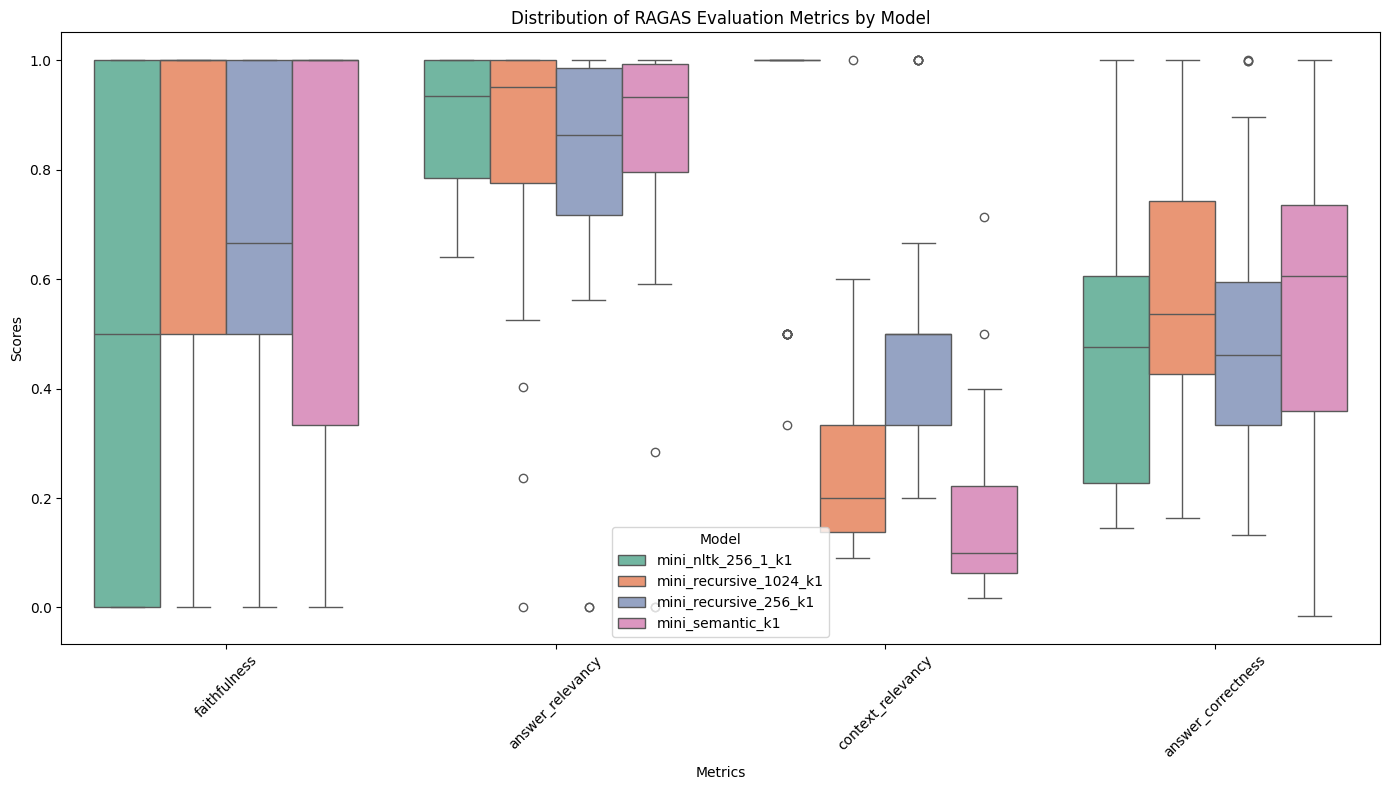


-------------------------------------------------------------------------------------------------------------------



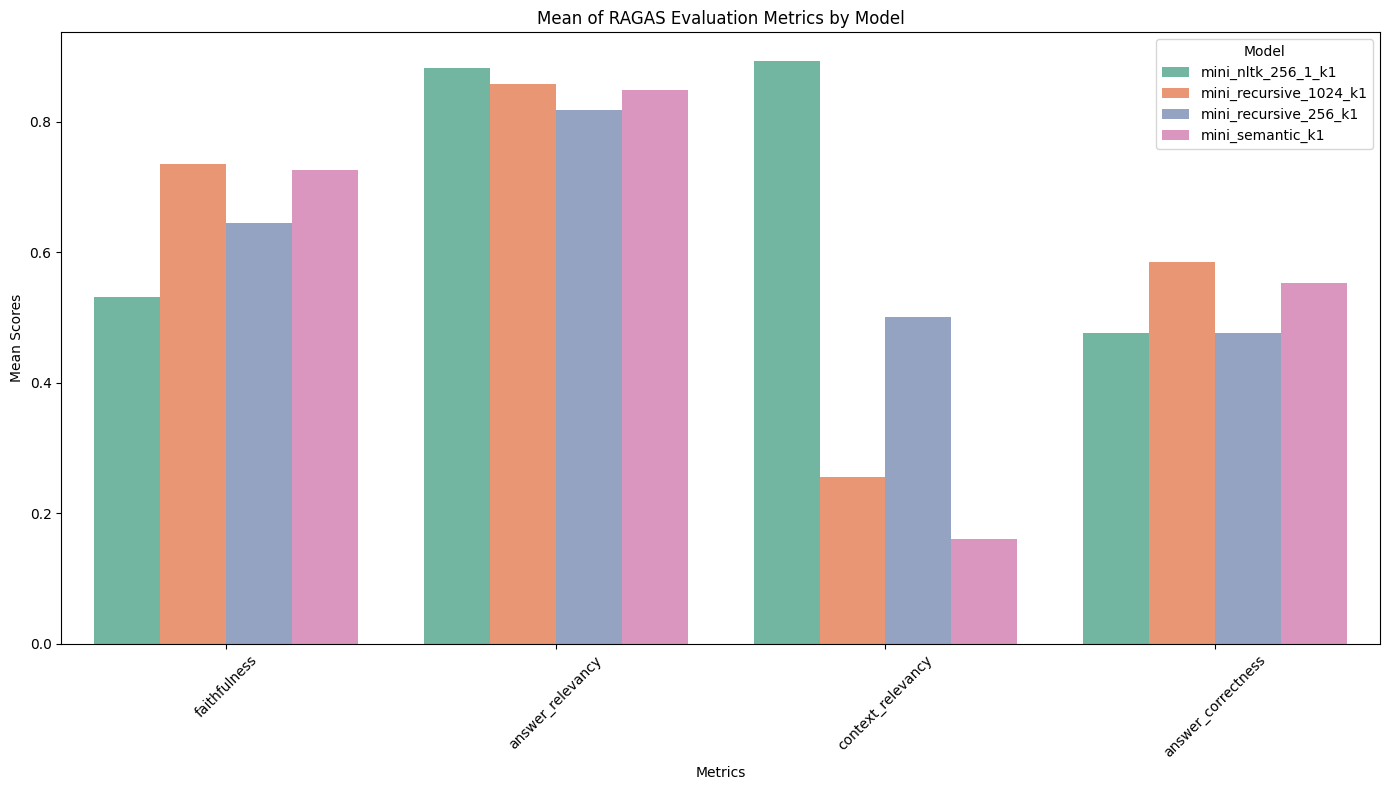

In [30]:
# List of dataset names corresponding to the evaluation results - k1
dataset_names_k1 = [
    "mini_recursive_256_k1",
    "mini_recursive_1024_k1",
    "mini_semantic_k1",
    "mini_nltk_256_1_k1"
]

# Loading the LLM evaluation results
llm_results_k1 = load_llm_results(dataset_names_k1)

# Plotting evaluations of multiple models together
plot_multiple_evals(llm_results_k1)


Computing metrics for mini_recursive_256_k1...


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Metrics for mini_recursive_256_k1:
  ROUGE-1: 0.46128801961468524
  ROUGE-2: 0.33337167767444836
  Mean Perplexity: 80.49376742045085
  Precision: 0.9355770212908586
  Recall: 0.8990246877074242
  F1 Score: 0.9166897758841515


Computing metrics for mini_recursive_1024_k1...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_recursive_1024_k1:
  ROUGE-1: 0.5554397742969548
  ROUGE-2: 0.43096317212120844
  Mean Perplexity: 60.12450091044108
  Precision: 0.9408157554765543
  Recall: 0.919844713062048
  F1 Score: 0.9299756959080696


Computing metrics for mini_semantic_k1...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_semantic_k1:
  ROUGE-1: 0.5157586614996975
  ROUGE-2: 0.3825880722278405
  Mean Perplexity: 60.22700150807699
  Precision: 0.9296044806639353
  Recall: 0.9169178282221159
  F1 Score: 0.9228584170341492


Computing metrics for mini_nltk_256_1_k1...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_nltk_256_1_k1:
  ROUGE-1: 0.4819068139211089
  ROUGE-2: 0.36385243834614744
  Mean Perplexity: 75.21299481391907
  Precision: 0.94034294039011
  Recall: 0.9071672558784485
  F1 Score: 0.9231457263231277



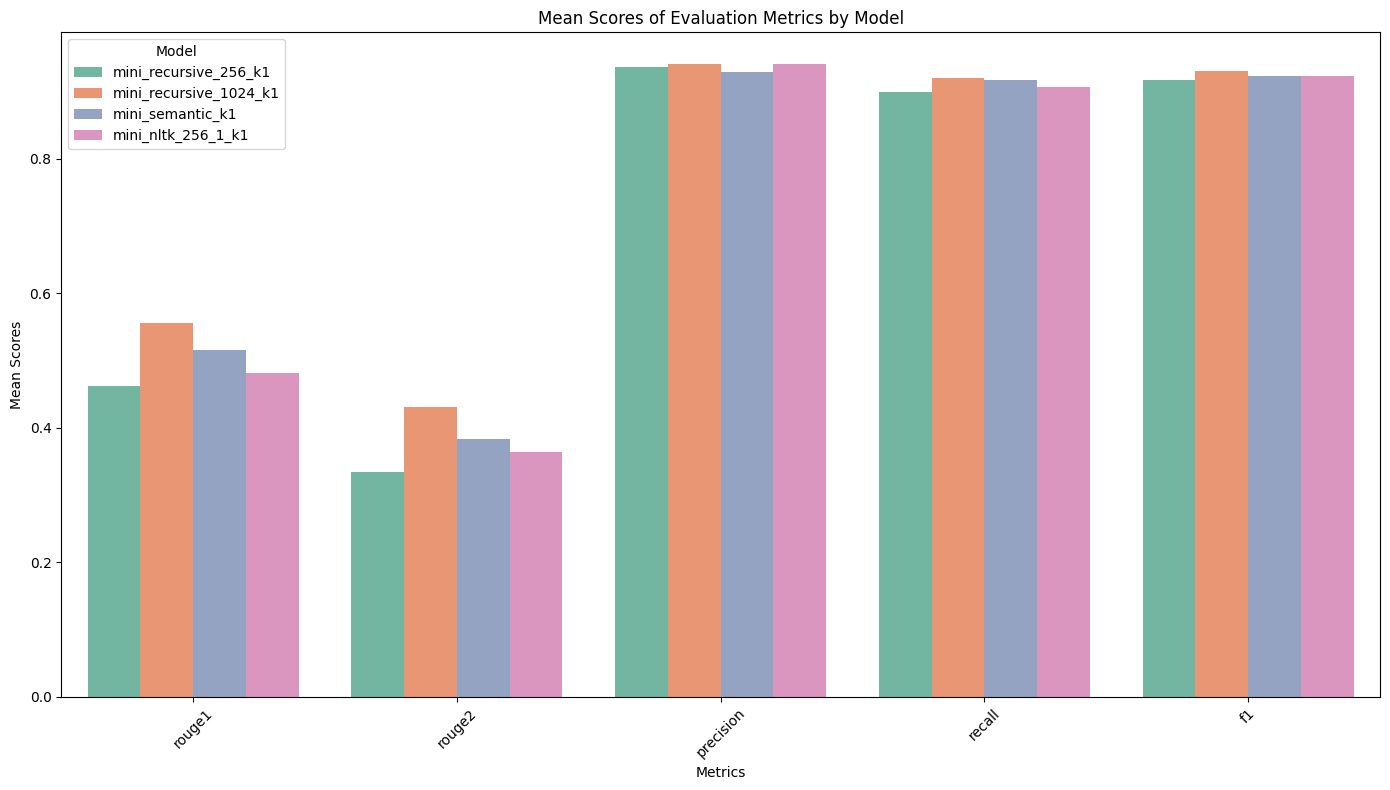

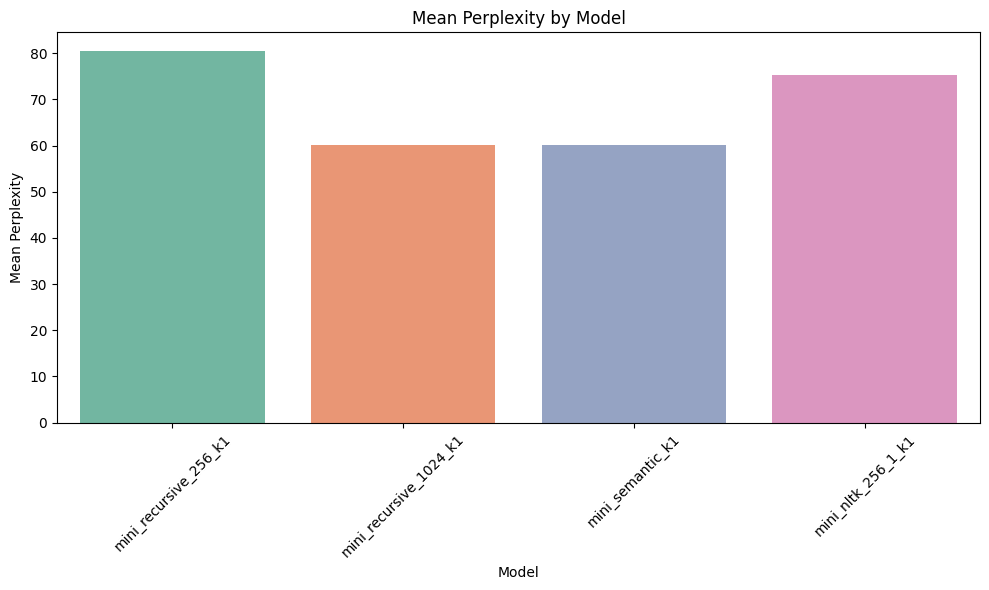

In [32]:
# Computing the metrics for LLM results
metrics_results = compute_metrics(llm_results_k1)  # Ensure this is defined

# Defining the metric names you want to plot (excluding perplexity)
metric_names = ['rouge1', 'rouge2', 'precision', 'recall', 'f1']

# Ploting the means of the specified metrics (excluding perplexity)
plot_multiple_means(metrics_results, metric_names)

# Ploting Perplexity separately
plot_perplexity(metrics_results)

Loaded mini_recursive_256_k3 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_recursive_256_k3_llm_eval_results.csv
Loaded mini_recursive_1024_k3 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_recursive_1024_k3_llm_eval_results.csv
Loaded mini_semantic_k3 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_semantic_k3_llm_eval_results.csv


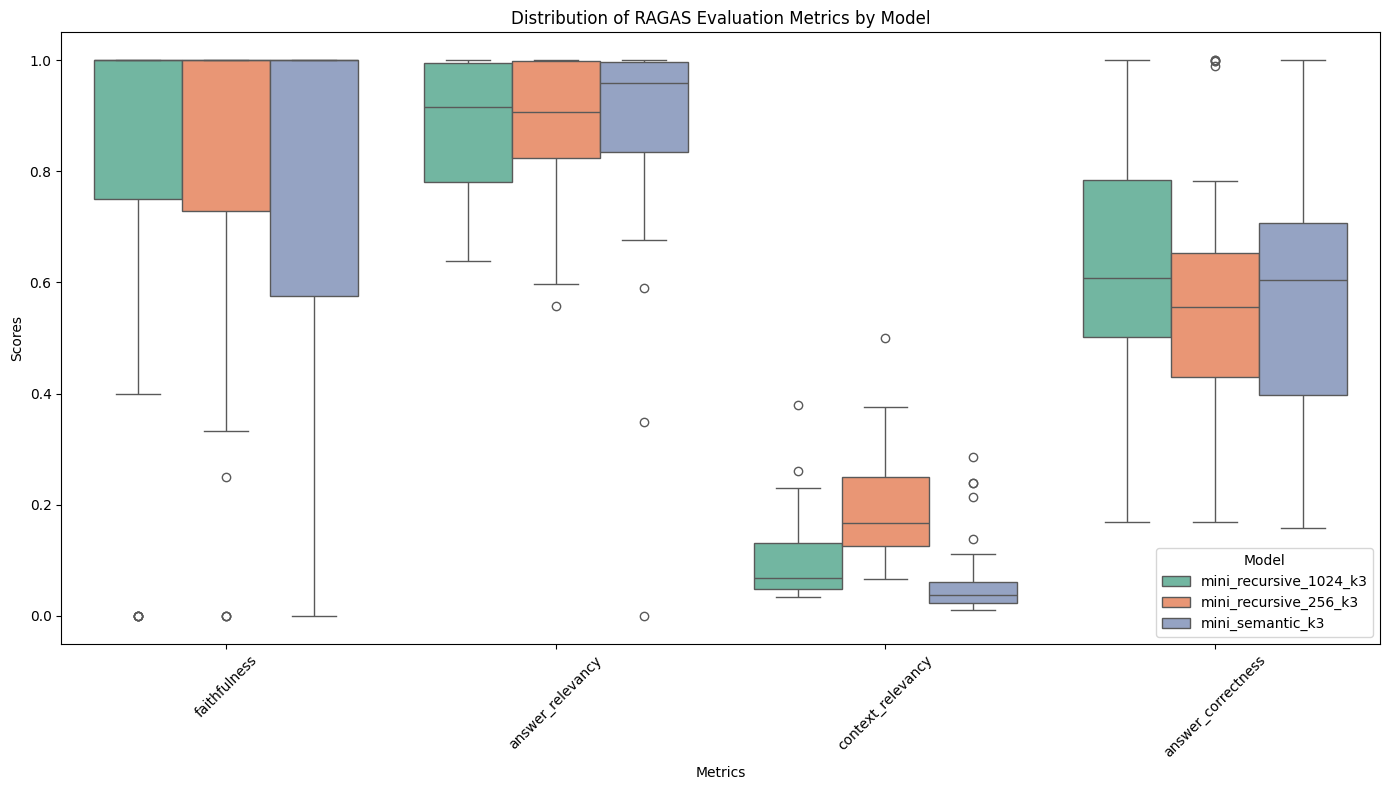


-------------------------------------------------------------------------------------------------------------------



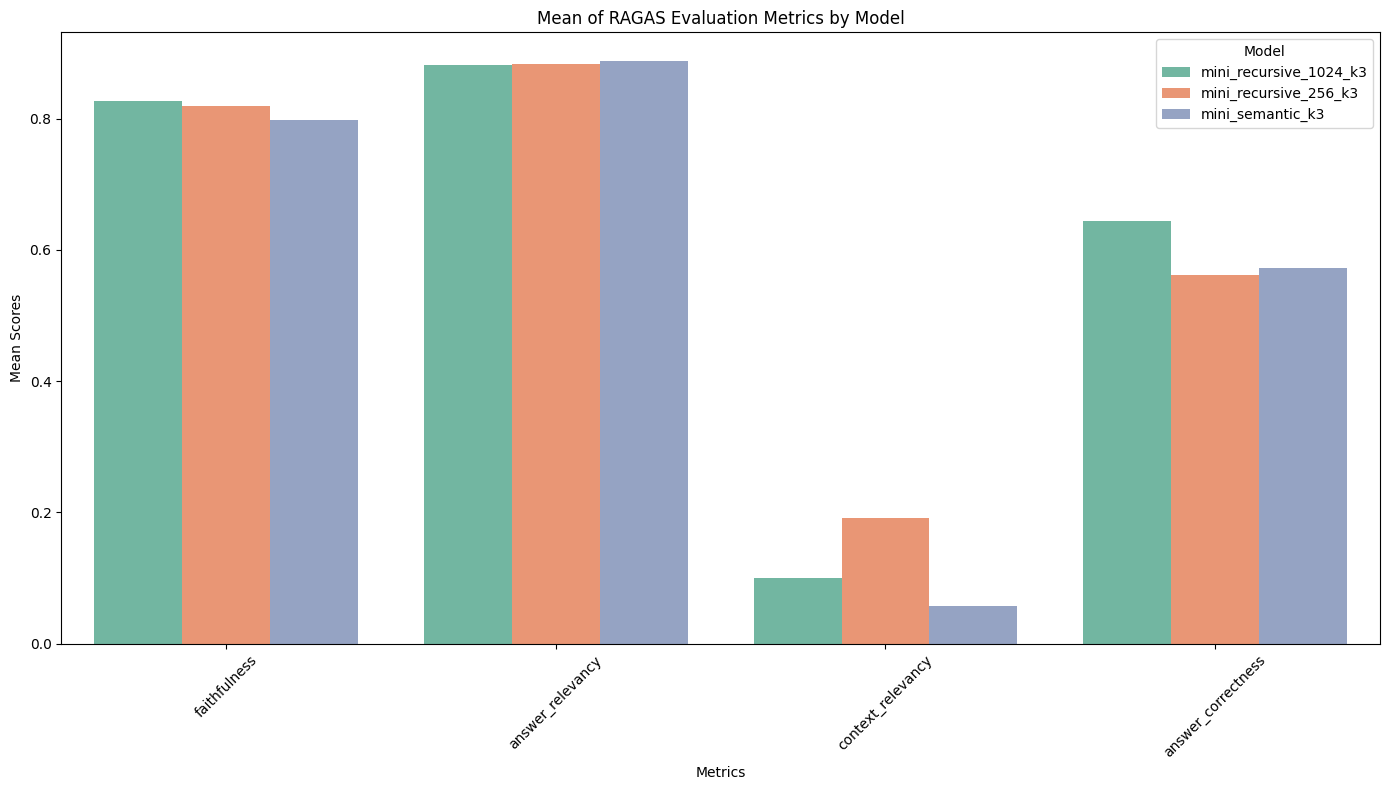

In [38]:
# List of dataset names corresponding to the evaluation results - k3
dataset_names_k3 = [
    "mini_recursive_256_k3",
    "mini_recursive_1024_k3",
    "mini_semantic_k3",
    # Unfortunately I couldn't run this - "mini_nltk_256_k3"
]

# Loading the LLM evaluation results
llm_results_k3 = load_llm_results(dataset_names_k3)

# Plotting evaluations of multiple models together
plot_multiple_evals(llm_results_k3)


Computing metrics for mini_recursive_256_k3...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_recursive_256_k3:
  ROUGE-1: 0.5036073617478669
  ROUGE-2: 0.369360659727888
  Mean Perplexity: 77.092542608579
  Precision: 0.9368191907803217
  Recall: 0.9085367545485497
  F1 Score: 0.922209749619166


Computing metrics for mini_recursive_1024_k3...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_recursive_1024_k3:
  ROUGE-1: 0.5735951559284853
  ROUGE-2: 0.4362811447936999
  Mean Perplexity: 52.18756397565206
  Precision: 0.9380288148919741
  Recall: 0.927380558103323
  F1 Score: 0.932381559163332


Computing metrics for mini_semantic_k3...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_semantic_k3:
  ROUGE-1: 0.5357830926552782
  ROUGE-2: 0.3953388566276781
  Mean Perplexity: 52.35247584184011
  Precision: 0.9326913816233476
  Recall: 0.9234897258381048
  F1 Score: 0.9277241490781307



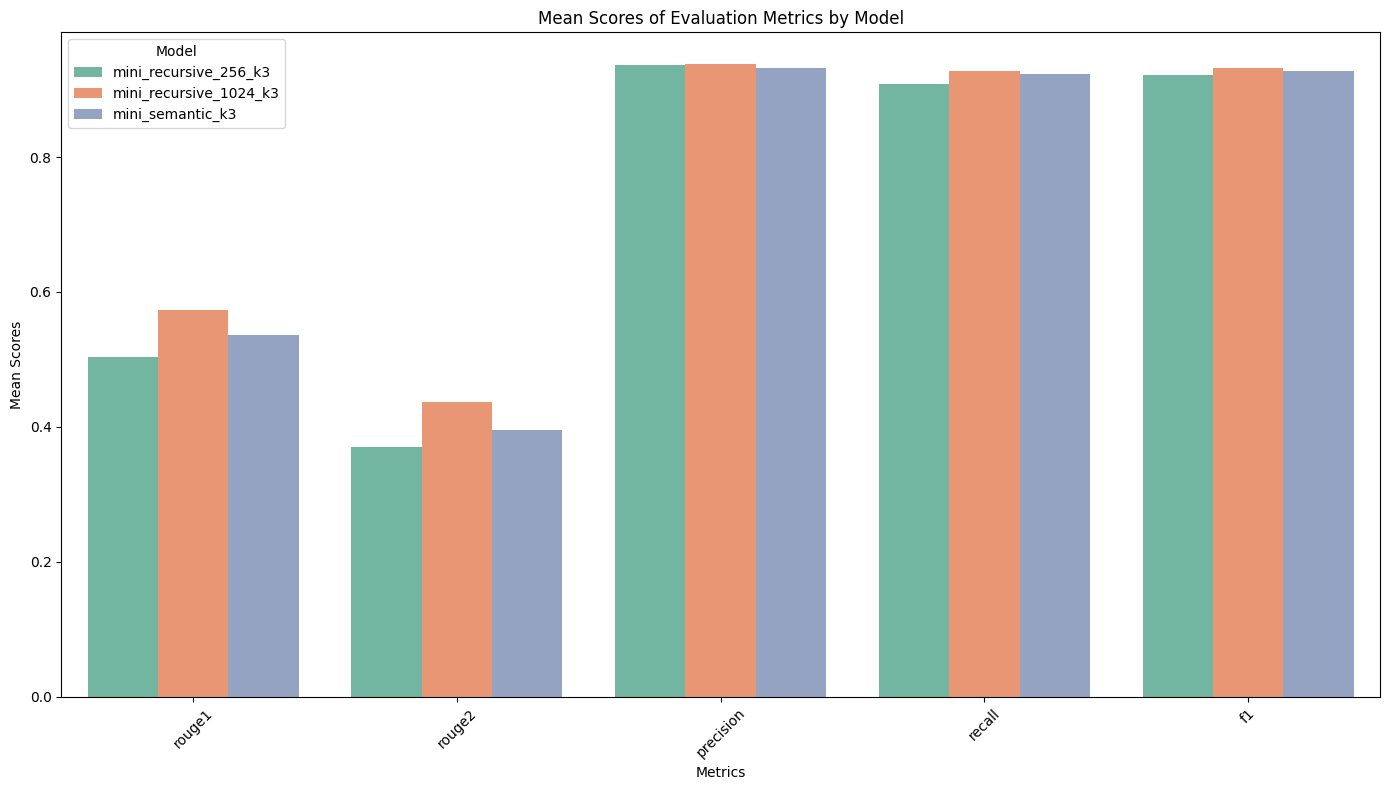

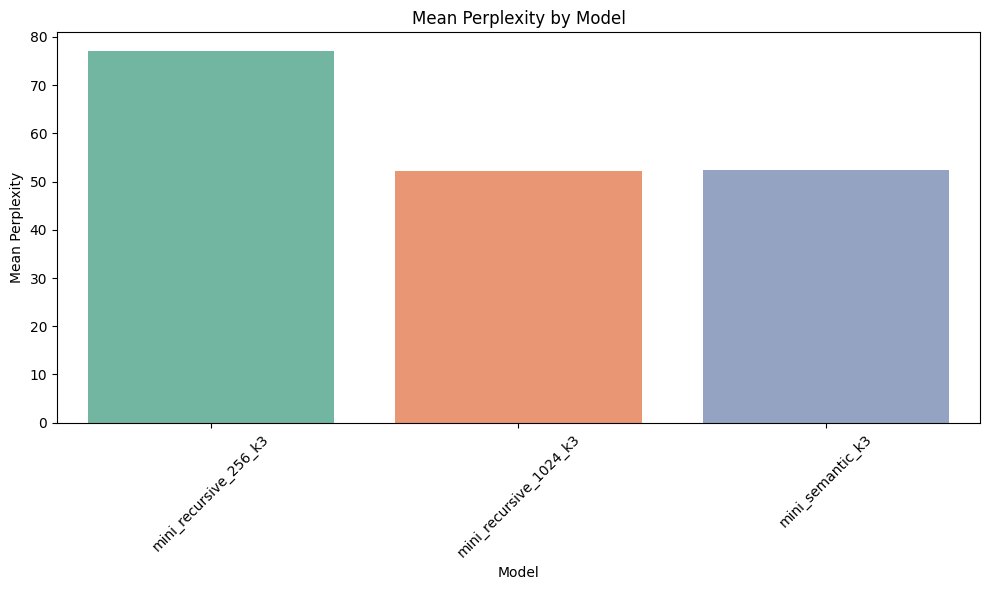

In [39]:
# Computing the metrics for LLM results
metrics_results = compute_metrics(llm_results_k3)  # Ensure this is defined

# Defining the metric names you want to plot (excluding perplexity)
metric_names = ['rouge1', 'rouge2', 'precision', 'recall', 'f1']

# Plotting the means of the specified metrics (excluding perplexity)
plot_multiple_means(metrics_results, metric_names)

# Ploting Perplexity separately
plot_perplexity(metrics_results)

Loaded mini_recursive_256_k5 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_recursive_256_k5_llm_eval_results.csv
Loaded mini_recursive_1024_k5 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_recursive_1024_k5_llm_eval_results.csv
Loaded mini_semantic_k5 evaluation results from /content/drive/My Drive/Colab Notebooks/Final Project Updated/gold/results/mini_semantic_k5_llm_eval_results.csv


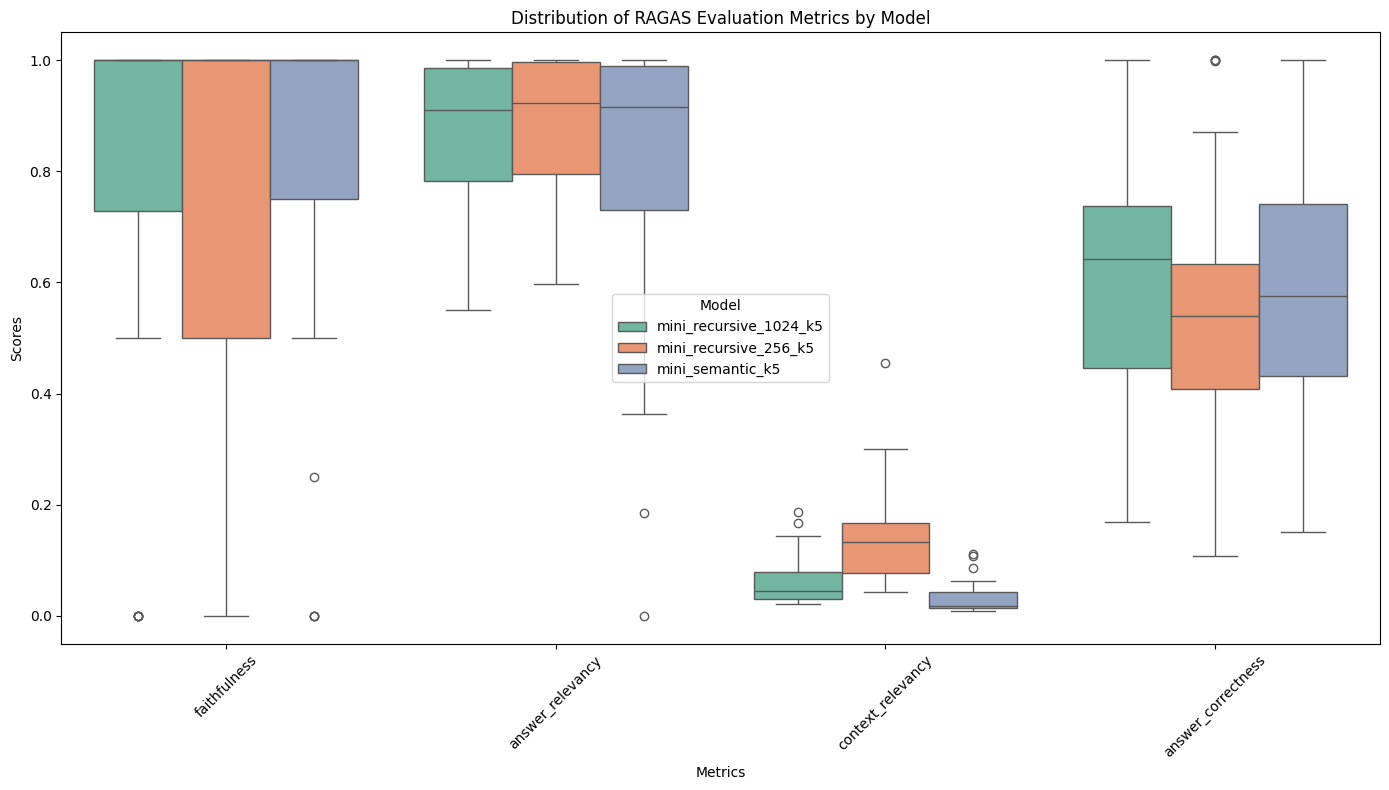


-------------------------------------------------------------------------------------------------------------------



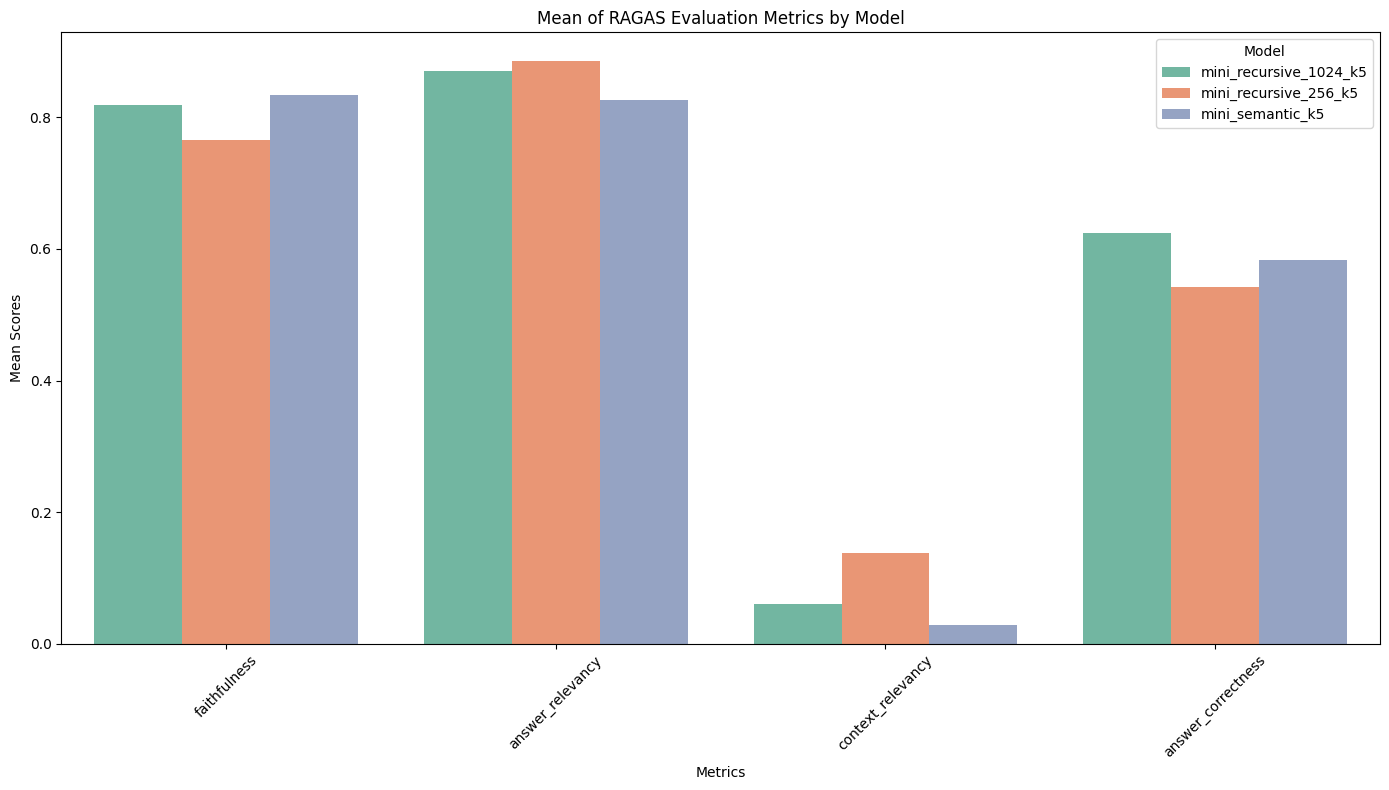

In [40]:
# List of dataset names corresponding to the evaluation results for k5
dataset_names_k5 = [
    "mini_recursive_256_k5",
    "mini_recursive_1024_k5",
    "mini_semantic_k5",
    # Unfortunately couldn't run any of the following:
    # "mini_nltk_256_k5",
    # "mini_nltk_1024_k5",
    # "bge-m3_recursive_256_k5",
    # "bge-m3_recursive_1024_k5"
]

# Loading the LLM evaluation results
llm_results_k5 = load_llm_results(dataset_names_k5)

# Plotting evaluations of multiple models together
plot_multiple_evals(llm_results_k5)


Computing metrics for mini_recursive_256_k5...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_recursive_256_k5:
  ROUGE-1: 0.5063770023215435
  ROUGE-2: 0.3704839115886976
  Mean Perplexity: 64.6112866004308
  Precision: 0.9338220357894897
  Recall: 0.9110991706450781
  F1 Score: 0.9220603456099828


Computing metrics for mini_recursive_1024_k5...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_recursive_1024_k5:
  ROUGE-1: 0.5751119631154473
  ROUGE-2: 0.44598130424622784
  Mean Perplexity: 53.84312023719152
  Precision: 0.9400343013306459
  Recall: 0.92767766614755
  F1 Score: 0.9335079528391361


Computing metrics for mini_semantic_k5...


  0%|          | 0/3 [00:00<?, ?it/s]

Metrics for mini_semantic_k5:
  ROUGE-1: 0.5606199328542671
  ROUGE-2: 0.4235435579749679
  Mean Perplexity: 49.57638223965963
  Precision: 0.9328701868653297
  Recall: 0.9268031778434912
  F1 Score: 0.929572639365991



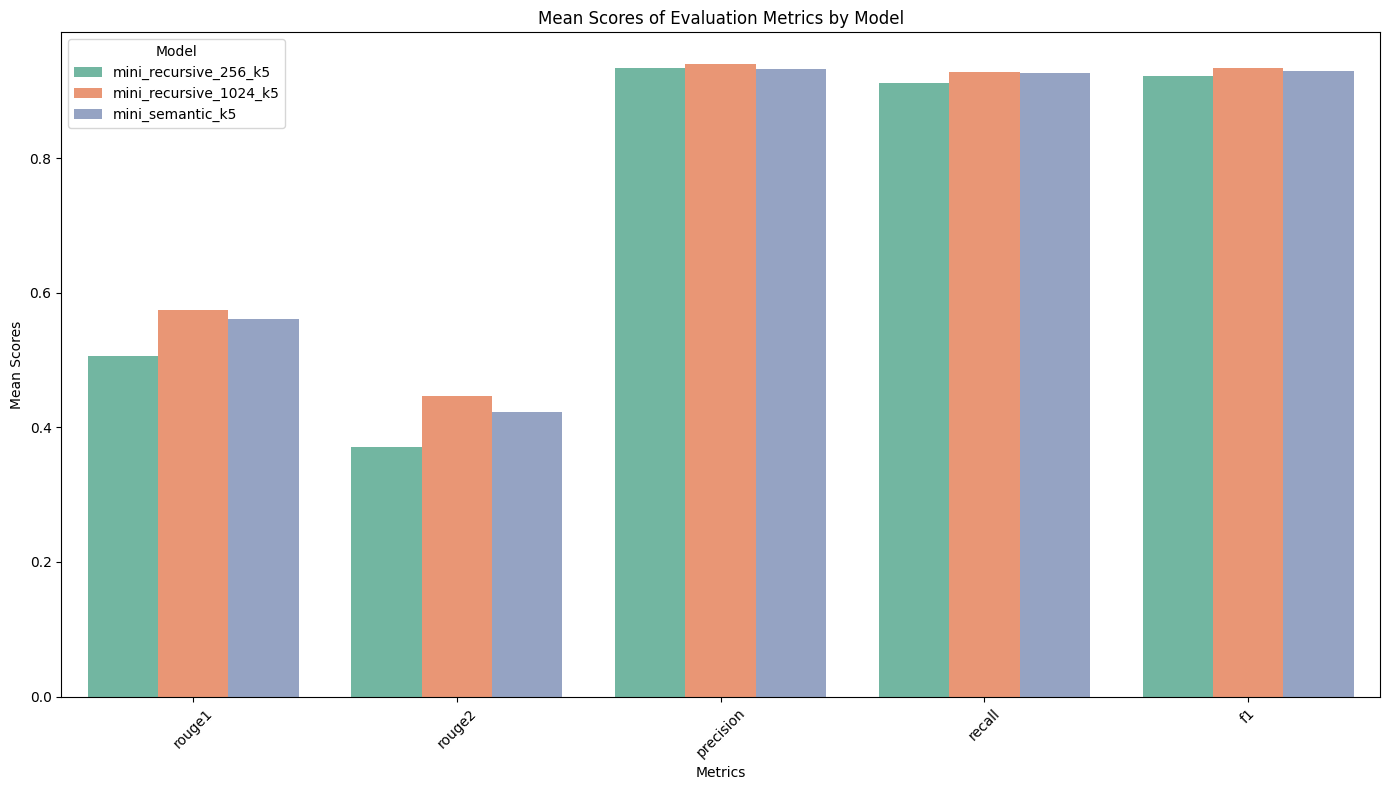

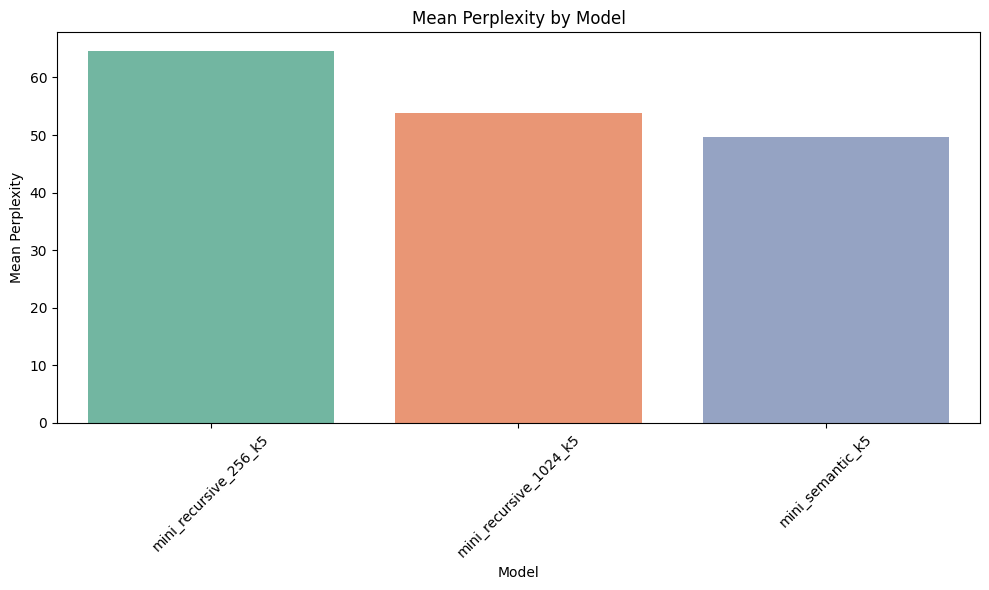

In [42]:
# Computing the metrics for LLM results
metrics_results = compute_metrics(llm_results_k5)

# Defining the metric names you want to plot (excluding perplexity)
metric_names = ['rouge1', 'rouge2', 'precision', 'recall', 'f1']

# Ploting the means of the specified metrics (excluding perplexity)
plot_multiple_means(metrics_results, metric_names)

# Plotting the Perplexity separately
plot_perplexity(metrics_results)